<a href="https://colab.research.google.com/github/gennadygorin/seq-cme-technoise/blob/dev/gg220406_refactor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Markov chains for length bias quantification in scRNA-seq: a Colab demonstration

slowly but surely


In [1]:
# from datetime import datetime
# import os
# code_ver_global='020'
# import logging
# import sys

# logging.basicConfig(stream=sys.stdout)
# log = logging.getLogger()
# log.setLevel(logging.DEBUG)

In [2]:
# %%capture
# !pip install loompy
# !pip install numdifftools

In [3]:
# import loompy as lp

In [132]:

# import collections
import numpy as np
# import sklearn
# import warnings
# import matplotlib.pyplot as plt
# import csv

In [2]:
dataset_names = ['brain_5k_v3','brain_nuc_5k_v3'] 
loom_filepaths = ['/home/ggorin/count_data/loom_10x_kb/'+x+'.loom' for x in dataset_names] 

transcriptome_filepath = './polyA_ref/gg_200524_mouse_genome_polyA_cum_1'
attribute_names=['spliced','unspliced','gene_name','barcode']

In [ ]:
# with lp.connect(filename) as ds:
#     S = ds.layers[spliced_layer][:]
#     U = ds.layers[unspliced_layer][:]
#     gene_names = ds.ra[gene_attr]
#     nCells = len(ds.ca[cell_attr])


In [102]:
import pandas as pd
allen_membership = pd.read_csv('~/count_data/allen_metadata/cluster.membership.csv',\
                               skiprows = 1, names=['barcode','cluster_id'])
allen_annot = pd.read_csv('~/count_data/allen_metadata/cluster.annotation.csv')

In [104]:
annot_bcs = list(allen_membership['barcode'])
annot_cid = np.asarray(allen_membership['cluster_id'])
annot_org = np.asarray([x[-3:] for x in allen_bcs])
annot_bcs = np.asarray([x[:16] for x in allen_bcs])
annot_n = len(allen_bcs)

In [105]:
celltype_names = ['GABAergic','Glutamatergic']
celltype_abbr = ['gaba','glu']

In [107]:
celltype_clusters = [np.where(allen_annot['class_label'] == x)[0] for x in celltype_names]

In [122]:
cluster_dict = {x:0 for x in celltype_clusters[0]}|{x:1 for x in celltype_clusters[1]}
annot_cid_collapsed = np.asarray([cluster_dict.get(x) for x in annot_cid])

In [124]:
annot_cid_collapsed[:10]==1

array([ True,  True,  True,  True, False, False, False,  True,  True,
       False])

In [109]:
import loompy as lp


In [133]:
meta = ['A08','B01','B08','C01']
filenames = ['/home/ggorin/count_data/loom_allen_kb/allen_{}_raw.loom'.format(x) for x in meta]
filtered_dir = '/home/ggorin/count_data/loom_allen_celltype_kb'

In [ ]:
for i in range(1,len(meta)):
    for j in range(len(celltype_names)):
        construct_loom(meta[i],celltype_names[j],celltype_abbr[j])

Barcodes associated with GABAergic cluster: 765
Spliced barcodes: 765
Unspliced barcodes: 765
Gene list constructed.
Spliced matrix constructed.
Unspliced matrix constructed.
Loom file written.
Barcodes associated with Glutamatergic cluster: 6494
Spliced barcodes: 6494
Unspliced barcodes: 6494
Gene list constructed.


just recycle the previous one... no need to reinvent this particular wheel. It's incredibly slow, though.


In [130]:
def construct_loom(dataset,cluster_name,celltype_abbr):
    cluster_annot = pd.read_csv('~/count_data/allen_metadata/cluster.annotation.csv')
    cluster_memb = pd.read_csv('~/count_data/allen_metadata/cluster.membership.csv',names=['barcode','cluster'],\
                               dtype={'barcode':str,'cluster':int},header=0)
    
    cluster_indx = list(cluster_annot[cluster_annot['class_label']==cluster_name]['cluster_id'])
    bc_len = 16
    bc = list(cluster_memb[(cluster_memb['barcode'].str[-3:]==dataset) & (cluster_memb['cluster'].isin(cluster_indx))]['barcode'].str[:bc_len])
    print('Barcodes associated with {} cluster: {:.0f}'.format(cluster_name,len(bc)))
    
    spl_bcs = []
    spl_dict = {}
    with open("/home/ggorin/count_data/allen_{}/counts_unfiltered/spliced.barcodes.txt".format(dataset),'r') as spl_bc:
        i = 1
        for line in spl_bc:
            if line[:bc_len] in bc:
                spl_bcs.append(i)
                spl_dict[i] = bc.index(line[:bc_len])
            i+= 1
            
    unspl_bcs = []
    unspl_dict = {}
    with open("/home/ggorin/count_data/allen_{}/counts_unfiltered/unspliced.barcodes.txt".format(dataset),'r') as unspl_bc:
        i = 1
        for line in unspl_bc:
            if line[:bc_len] in bc:
                unspl_bcs.append(i)
                unspl_dict[i] = bc.index(line[:bc_len])
            i+= 1
    
    print('Spliced barcodes: {:.0f}'.format(len(spl_bcs)))
    print('Unspliced barcodes: {:.0f}'.format(len(unspl_bcs)))
#     print(len(unspl_bcs))
    
    gene_id = []
    with open("/home/ggorin/count_data/allen_{}/counts_unfiltered/unspliced.genes.txt".format(dataset),'r') as genelist:
        for line in genelist:
            gene_id.append(line.strip())
            
    cell_count = len(bc)
    gene_count = len(gene_id)
    
    gene_names = ['']*gene_count
    with open("/home/ggorin/ref/refdata-gex-mm10-2020-A/t2g_mm10.txt",'r') as t2g:
        for line in t2g:
            L = line.split('\t')
            try:
                gene_names[gene_id.index(L[1])] = L[2]
            except:
                print('Gene {} not in dataset.'.format(L[1]))
    
    print('Gene list constructed.')
    
    spliced = np.zeros((gene_count,cell_count))
    unspliced = np.zeros((gene_count,cell_count))
    
    with open("/home/ggorin/count_data/allen_{}/counts_unfiltered/spliced.mtx".format(dataset),'r') as data:
        i = 1
        for line in data:
            if i>4:
                L = [int(x) for x in line.split(' ')]
                if L[0] in spl_bcs:
                    spliced[L[1]-1,spl_dict[L[0]]] = L[2]
            i+=1
    print('Spliced matrix constructed.')
        
    with open("/home/ggorin/count_data/allen_{}/counts_unfiltered/unspliced.mtx".format(dataset),'r') as data:
        i = 1
        for line in data:
            if i>4:
                L = [int(x) for x in line.split(' ')]
                if L[0] in unspl_bcs:
                    unspliced[L[1]-1,unspl_dict[L[0]]] = L[2]
            i+=1
    print('Unspliced matrix constructed.')
    import scipy.sparse
    lp.create('/home/ggorin/count_data/loom_allen_celltype_kb/allen_{}_{}.loom'.format(dataset,celltype_abbr),\
              layers={'':scipy.sparse.csr_matrix(spliced.shape),'spliced':spliced,'unspliced':unspliced},\
              row_attrs={'gene_id':gene_id,'gene_name':gene_names},\
              col_attrs={'barcode':bc})
    print('Loom file written.')


In [125]:
# for i in range(len(filenames)):
#     fn = filenames[i]
#     with lp.connect(fn) as ds:
#         print('==========')
#         print('Dataset: {}.'.format(meta[i]))
#         bcs = ds.ca['barcode']
#         print('Barcodes detected in loom: {:.0f}.'.format(len(bcs)))
        
#         filt = allen_org==meta[i]
#         print('Barcodes detected in annotations: {:.0f}.'.format(sum(filt)))
        
#         annotation_bcs = allen_bcs[filt]
        
# #         filt_intersect = []
# #         intersect_bcs = list(set(bcs).intersection(set(annotation_bcs)))
#         print('Intersecting barcodes: {:.0f}.'.format(sum(filt_intersect)))
#         print('-----------')
#         for j in range(len(celltype_names)):
#             print('Cell type: {}.'.format(celltype_names[j]))
            
#             filt_ct = np.logical_and(filt,annot_cid_collapsed==j)
#             print('Barcodes: {:.0f}.'.format(sum(filt_ct)))
            
# #     print
# #     S = ds.layers[spliced_layer][:]
# #     U = ds.layers[unspliced_layer][:]
# #     gene_names = ds.ra[gene_attr]
# #     nCells = len(ds.ca[cell_attr])


Dataset: A08.
Barcodes detected in loom: 9974.
Barcodes detected in annotations: 7897.
Intersecting barcodes: 7897.
-----------
Cell type: GABAergic.
Barcodes: 725.
Cell type: Glutamatergic.
Barcodes: 5009.
Dataset: B01.
Barcodes detected in loom: 11504.
Barcodes detected in annotations: 9772.
Intersecting barcodes: 9772.
-----------
Cell type: GABAergic.
Barcodes: 765.
Cell type: Glutamatergic.
Barcodes: 6490.
Dataset: B08.
Barcodes detected in loom: 10975.
Barcodes detected in annotations: 8424.
Intersecting barcodes: 8424.
-----------
Cell type: GABAergic.
Barcodes: 847.
Cell type: Glutamatergic.
Barcodes: 5377.
Dataset: C01.
Barcodes detected in loom: 12363.
Barcodes detected in annotations: 10173.
Intersecting barcodes: 10138.
-----------
Cell type: GABAergic.
Barcodes: 750.
Cell type: Glutamatergic.
Barcodes: 6697.


In [135]:
from preprocess import *

In [136]:
dataset_meta = ['A08', 'B01','B08','C01']
cluster_names = ['gaba','glu']
dataset_names = ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names] 
loom_filepaths = ['/home/ggorin/count_data/loom_allen_celltype_kb/'+x+'.loom' for x in dataset_names] 

transcriptome_filepath = './polyA_ref/gg_200524_mouse_genome_polyA_cum_1'
attribute_names=['spliced','unspliced','gene_name','barcode']

In [138]:
loom_filepaths

['/home/ggorin/count_data/loom_allen_celltype_kb/allen_A08_gaba.loom',
 '/home/ggorin/count_data/loom_allen_celltype_kb/allen_A08_glu.loom',
 '/home/ggorin/count_data/loom_allen_celltype_kb/allen_B01_gaba.loom',
 '/home/ggorin/count_data/loom_allen_celltype_kb/allen_B01_glu.loom',
 '/home/ggorin/count_data/loom_allen_celltype_kb/allen_B08_gaba.loom',
 '/home/ggorin/count_data/loom_allen_celltype_kb/allen_B08_glu.loom',
 '/home/ggorin/count_data/loom_allen_celltype_kb/allen_C01_gaba.loom',
 '/home/ggorin/count_data/loom_allen_celltype_kb/allen_C01_glu.loom']

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_220422_020_allen_celltypes_1 created.
INFO:root:Dataset: allen_A08_gaba
INFO:root:730 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:6150 genes retained after expression filter.
INFO:root:Directory ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba created.
INFO:root:Dataset: allen_A08_glu
INFO:root:5010 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:8027 genes retained after expression filter.
INFO:root:Directory ./fits/gg_220422_020_allen_celltypes_1/allen_A08_glu created.
INFO:root:Dataset: allen_B01_gaba
INFO:root:765 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:4591 genes retained after expression filter.
INFO:root:Directory ./fits/gg_220422_020_allen_celltypes_1/allen_B01_gaba created.
INFO:root:Datas

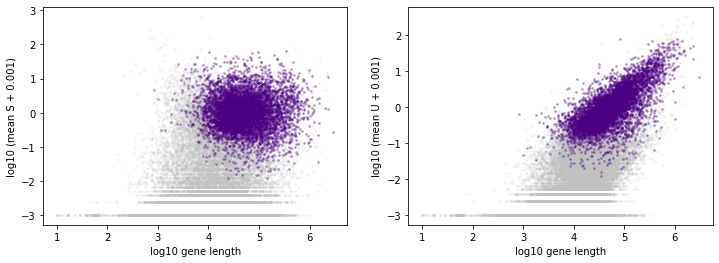

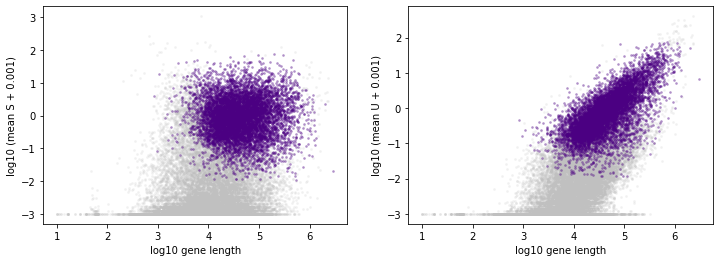

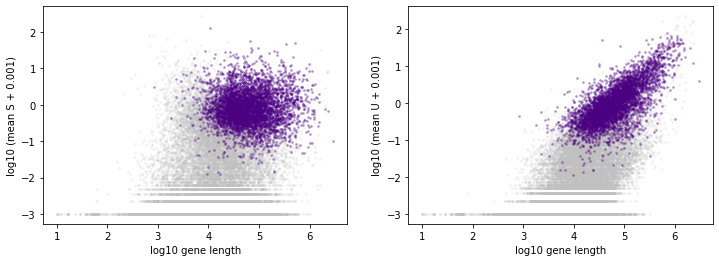

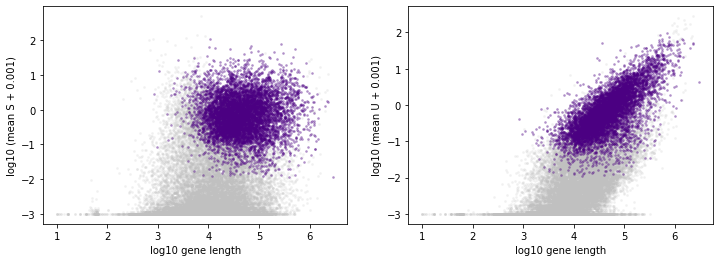

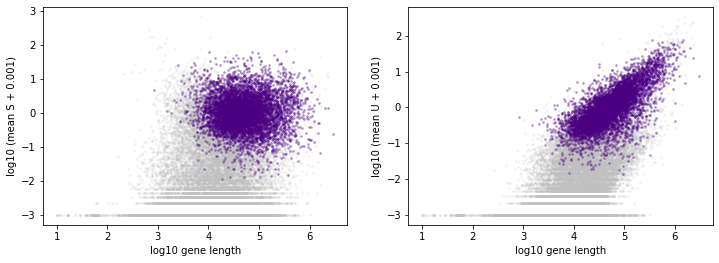

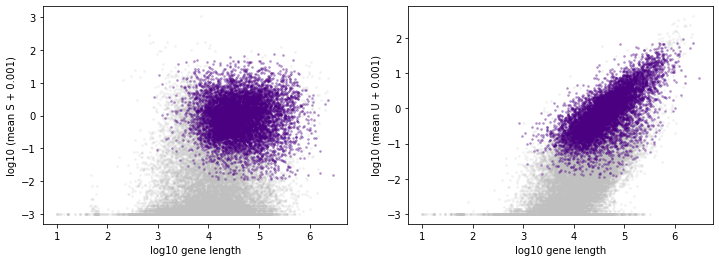

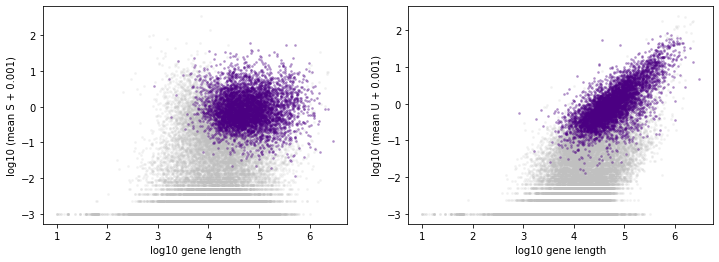

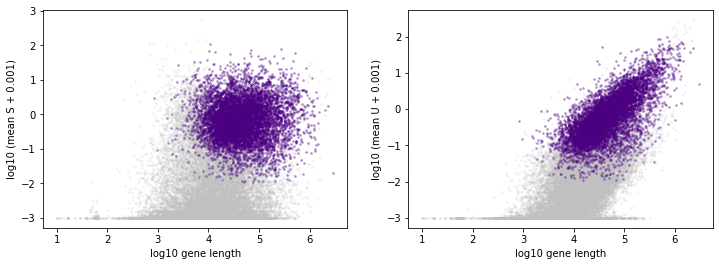

In [139]:
# !rm -r gg_*/
dir_string,dataset_strings = construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='allen_celltypes',batch_id=1,\
                                             n_genes=1000)

In [141]:
n_datasets = len(dataset_strings)

In [140]:
from extract_data import extract_data

/home/ggorin/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's try the no-sampling model.

In [ ]:
from cme_toolbox import CMEModel
fitmodel = CMEModel('Bursty','Poisson')
from inference import InferenceParameters, GradientInference


result_strings = []
search_data_arr = []
for j in range(n_datasets):
    inference_parameters = InferenceParameters([-1, -1.8, -1.8 ],\
                [4.2, 2.5, 3.5],[-8, -3.5],[-3, 1],[15,15],\
                dataset_strings[j],fitmodel,use_lengths = True)
    search_data = extract_data(loom_filepaths[j], transcriptome_filepath, dataset_names[j],
                        dataset_strings[j], dir_string, dataset_attr_names=attribute_names)
    search_data_arr.append(search_data)
    full_result_string = inference_parameters.fit_all_grid_points(40,search_data)
    result_strings.append(full_result_string)

INFO:root:Directory ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15 created.
INFO:root:Global inference parameters stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_A08_gaba
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_220422_020_allen_celltypes_1/genes.csv.
INFO:root:Directory ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/raw.sd.
INFO:root:Starting parallelized grid scan.
DEBUG:root:Grid point 12 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_12.gp.
DEBUG:root:Grid point 32 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_32.gp.
DEBUG

DEBUG:root:Grid point 25 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_25.gp.
DEBUG:root:Grid point 83 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_83.gp.
DEBUG:root:Grid point 19 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_19.gp.
DEBUG:root:Grid point 17 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_17.gp.
DEBUG:root:Grid point 11 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_11.gp.
DEBUG:root:Grid point 57 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_57.gp.
DEBUG:root:Grid point 45 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_45.gp.
DEBUG:root:Grid point 81 results stored to ./fit

DEBUG:root:Grid point 116 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_116.gp.
DEBUG:root:Grid point 118 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_118.gp.
DEBUG:root:Grid point 128 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_128.gp.
DEBUG:root:Grid point 124 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_124.gp.
DEBUG:root:Grid point 95 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_95.gp.
DEBUG:root:Grid point 160 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_160.gp.
DEBUG:root:Grid point 106 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_106.gp.
DEBUG:root:Grid point 140 results st

DEBUG:root:Grid point 182 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_182.gp.
DEBUG:root:Grid point 145 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_145.gp.
DEBUG:root:Grid point 149 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_149.gp.
DEBUG:root:Grid point 188 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_188.gp.
DEBUG:root:Grid point 190 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_190.gp.
DEBUG:root:Grid point 175 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_175.gp.
DEBUG:root:Grid point 184 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_15x15/grid_point_184.gp.
DEBUG:root:Grid point 177 results 

DEBUG:root:Grid point 76 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_15x15/grid_point_76.gp.
DEBUG:root:Grid point 48 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_15x15/grid_point_48.gp.
DEBUG:root:Grid point 64 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_15x15/grid_point_64.gp.
DEBUG:root:Grid point 78 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_15x15/grid_point_78.gp.
DEBUG:root:Grid point 44 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_15x15/grid_point_44.gp.
DEBUG:root:Grid point 18 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_15x15/grid_point_18.gp.
DEBUG:root:Grid point 36 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_15x15/grid_point_36.gp.
DEBUG:root:Grid point 26 results stored to ./fits/gg_22

DEBUG:root:Grid point 85 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_15x15/grid_point_85.gp.
DEBUG:root:Grid point 89 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_15x15/grid_point_89.gp.
DEBUG:root:Grid point 55 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_15x15/grid_point_55.gp.
DEBUG:root:Grid point 91 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_15x15/grid_point_91.gp.
DEBUG:root:Grid point 31 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_15x15/grid_point_31.gp.
DEBUG:root:Grid point 61 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_15x15/grid_point_61.gp.
DEBUG:root:Grid point 39 results stored to ./fits/gg_220422_020_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_15x15/grid_point_39.gp.
DEBUG:root:Grid point 23 results stored to ./fits/gg_22

In [18]:
import importlib
# importlib.reload(analysis)


/home/ggorin/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [122]:
# import inference
# importlib.reload(inference)


<module 'inference' from '/home/ggorin/projects/seq-cme-technoise/inference.py'>

In [123]:
# importlib.reload(analysis)

# importlib.reload(plot_aesthetics)


<module 'analysis' from '/home/ggorin/projects/seq-cme-technoise/analysis.py'>

In [11]:
# import cme_toolbox



/home/ggorin/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [125]:
# importlib.reload(cme_toolbox)
# 

<module 'cme_toolbox' from '/home/ggorin/projects/seq-cme-technoise/cme_toolbox.py'>

In [ ]:
import analysis
from analysis import *
import inference
from inference import *

In [13]:
# res_strings = ['./gg_220410_020_batch_1/pbmc_1k_fbc/Bursty_Poisson_10x10/grid_scan_results.res',\
#                './gg_220410_020_batch_1/pbmc_1k_v3/Bursty_Poisson_10x10/grid_scan_results.res']
# search_data_strings = ['./gg_220410_020_batch_1/pbmc_1k_fbc/raw.sd',\
#                './gg_220410_020_batch_1/pbmc_1k_v3/raw.sd']
# dir_string = './gg_220410_020_batch_1'

In [14]:
# def load_search_data(search_data_string):
#     try:
#         with open(search_data_string,'rb') as sdfs:
#             sd = pickle.load(sdfs)
#         log.info('Search data loaded from {}.'.format(search_data_string))
#         return sd
#     except:
#         log.error('Search data could not be loaded from {}.'.format(search_data_string))


In [ ]:
result_strings

In [ ]:
sr_arr = []
sd_arr = search_data_arr

for j in range(n_datasets):
    sr = load_search_results(result_strings[j])
    # sd = load_search_data(search_data_strings[j])
    sd = sd_arr[j]
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()

    print(sr.samp_optimum)
    
    
    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)
    
    sr.plot_gene_distributions(sd,marg='joint')
    
    _=sr.chisquare_testing(sd)
    
    #these do not make sense to do for a single "virtual" grid point
    sr.resample_opt_viz(sd)
    sr.resample_opt_mc_viz(sd)
    sr.chisq_best_param_correction(sd,viz=True) 
#     print(sr.samp_optimum_ind)

    sr.compute_sigma(sd)
    sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
    sr.plot_param_marg()
    sr.update_on_disk()
    sr_arr.append(sr)

In [ ]:
for i in range(4):
    plot_params_for_pair(sr_arr[i*2-1],sr_arr[i*2],dir_string = dir_string,\
                         distinguish_rej=True,plot_errorbars=True,meta = dataset_meta[i])

Another one! but with delay now

INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Directory ./fits/gg_220420_020_nuc_1/brain_5k_v3/Delay_None_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_220420_020_nuc_1/brain_5k_v3/Delay_None_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: brain_5k_v3


/home/ggorin/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_220420_020_nuc_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_220420_020_nuc_1/brain_5k_v3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
DEBUG:root:Grid point 0 results stored to ./fits/gg_220420_020_nuc_1/brain_5k_v3/Delay_None_1x1/grid_point_0.gp.
INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_220420_020_nuc_1/brain_5k_v3/Delay_None_1x1/analysis_figures created.
DEBUG:root:Grid scan results stored to ./fits/gg_220420_020_nuc_1/brain_5k_v3/Delay_None_1x1/grid_scan_results.res.
INFO:root:Runtime: 51.5 seconds.
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Directory ./fits/gg_220420_020_nuc_1/brain_nuc_5k_v3/Delay_None_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_220420_020_nuc_1/brain_nuc_5k_v3/De

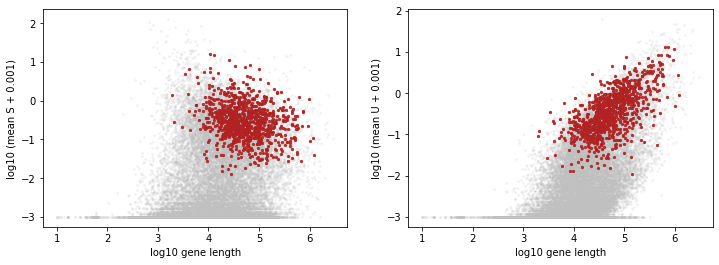

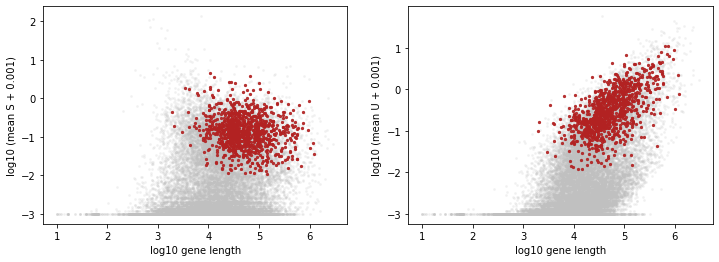

In [32]:
from cme_toolbox import CMEModel
fitmodel = CMEModel('Delay','None')
# fitmodel = CMEModel('Bursty','Poisson')
from inference import InferenceParameters, GradientInference


result_strings_del = []
for j in range(2):
    inference_parameters = InferenceParameters([-1, -1.8, -1.8 ],\
                [4.2, 2.5, 3.5],[-8, -3.5],[-3, 1],[15,15],\
                dataset_strings[j],fitmodel,use_lengths = False)
    search_data = extract_data(loom_filepaths[j], transcriptome_filepath, dataset_names[j],
                        dataset_strings[j], dir_string, dataset_attr_names=attribute_names)
    search_data_arr.append(search_data)
    full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
    result_strings_del.append(full_result_string)

DEBUG:root:Grid scan results loaded from ./fits/gg_220420_020_nuc_1/brain_5k_v3/Delay_None_1x1/grid_scan_results.res.
(1.0, 1.0)
INFO:root:Figure stored to ./fits/gg_220420_020_nuc_1/brain_5k_v3/Delay_None_1x1/analysis_figures/kldiv.png.


/home/ggorin/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


INFO:root:Figure stored to ./fits/gg_220420_020_nuc_1/brain_5k_v3/Delay_None_1x1/analysis_figures/gene_distributions_joint.png.


/home/ggorin/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:6707: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/home/ggorin/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:6707: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp


INFO:root:Chi-square computation complete. Rejected 102 genes out of 1000. Runtime: 0.9 seconds.
INFO:root:Computing local Hessian.
INFO:root:Gene 29 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 149 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 158 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 287 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 338 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 409 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 458 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 636 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 713 gives negative stdev; replaced with mean. (Search converged to loc

/home/ggorin/projects/seq-cme-technoise/inference.py:502: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index,:] = np.sqrt(np.diag(hess_inv))/np.sqrt(self.n_cells)


INFO:root:Figure stored to ./fits/gg_220420_020_nuc_1/brain_5k_v3/Delay_None_1x1/analysis_figures/length_dependence.png.


/home/ggorin/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:4154: RuntimeWarning: overflow encountered in double_scalars
  fac1 = a / np.pi * np.exp(gamma)
/home/ggorin/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:4154: RuntimeWarning: overflow encountered in exp
  fac1 = a / np.pi * np.exp(gamma)


INFO:root:Figure stored to ./fits/gg_220420_020_nuc_1/brain_5k_v3/Delay_None_1x1/analysis_figures/parameter_marginals.png.
DEBUG:root:Grid scan results loaded from ./fits/gg_220420_020_nuc_1/brain_nuc_5k_v3/Delay_None_1x1/grid_scan_results.res.
(1.0, 1.0)
INFO:root:Figure stored to ./fits/gg_220420_020_nuc_1/brain_nuc_5k_v3/Delay_None_1x1/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_220420_020_nuc_1/brain_nuc_5k_v3/Delay_None_1x1/analysis_figures/gene_distributions_joint.png.


/home/ggorin/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:6707: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp


INFO:root:Chi-square computation complete. Rejected 445 genes out of 1000. Runtime: 0.9 seconds.
INFO:root:Computing local Hessian.
INFO:root:Gene 158 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 171 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 233 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 287 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 338 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 409 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 723 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 176.7 seconds.


/home/ggorin/projects/seq-cme-technoise/inference.py:502: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index,:] = np.sqrt(np.diag(hess_inv))/np.sqrt(self.n_cells)


INFO:root:Figure stored to ./fits/gg_220420_020_nuc_1/brain_nuc_5k_v3/Delay_None_1x1/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_220420_020_nuc_1/brain_nuc_5k_v3/Delay_None_1x1/analysis_figures/parameter_marginals.png.


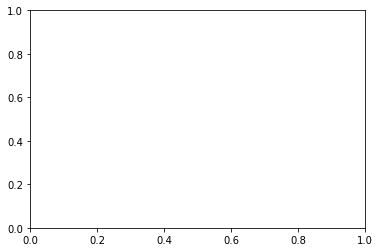

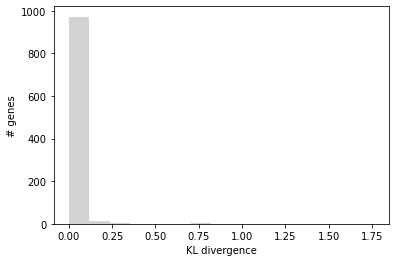

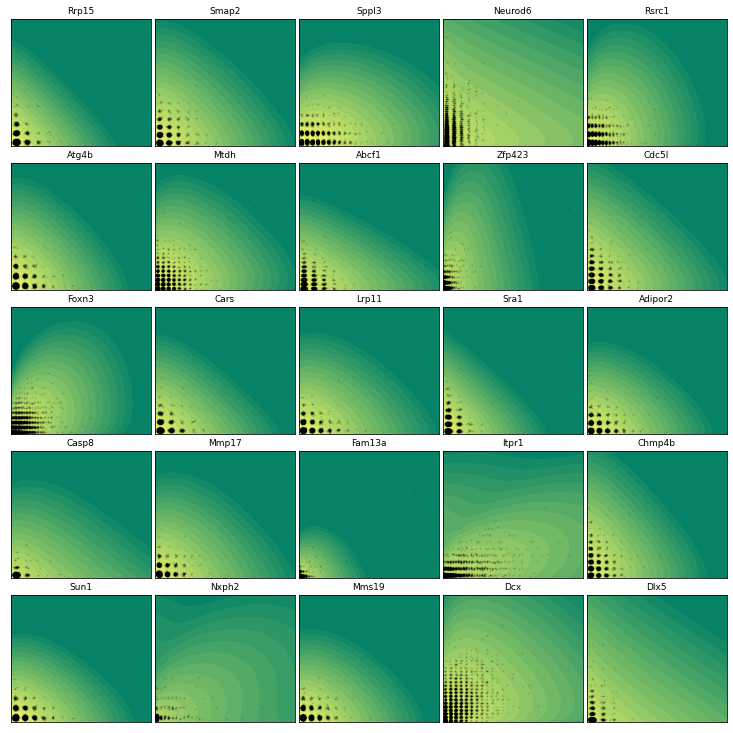

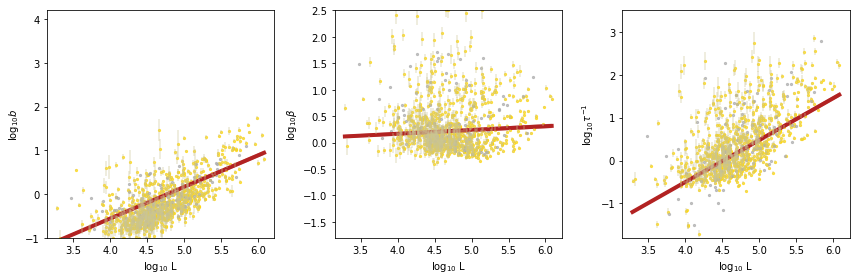

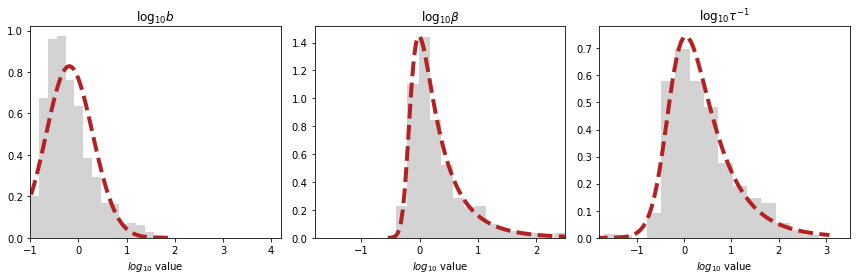

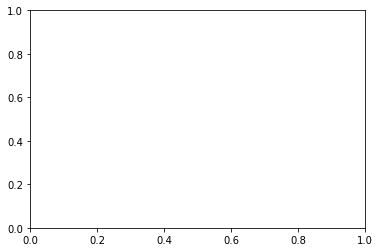

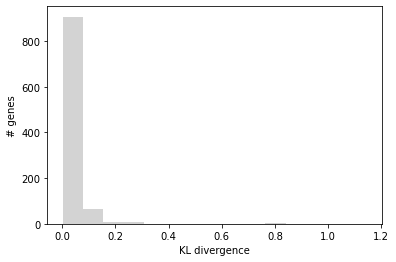

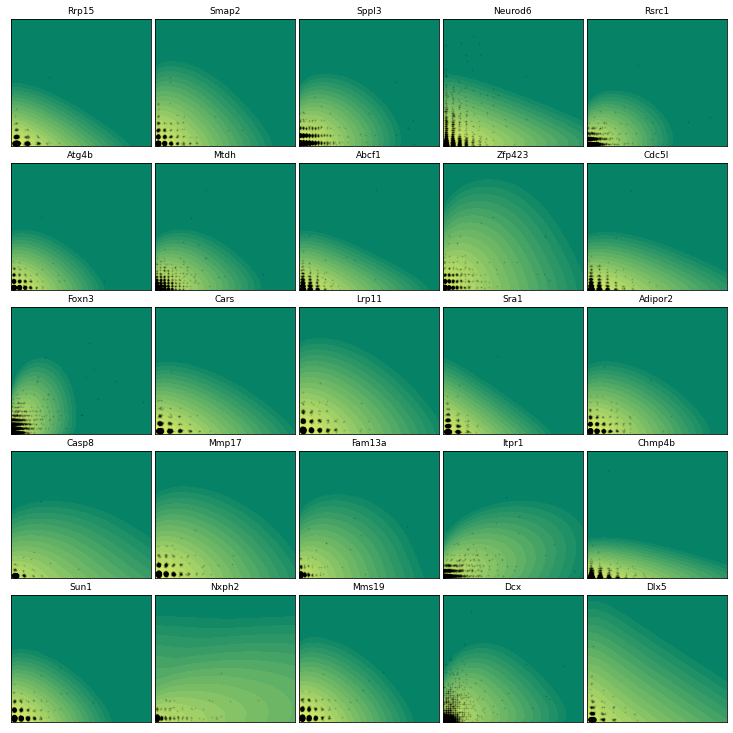

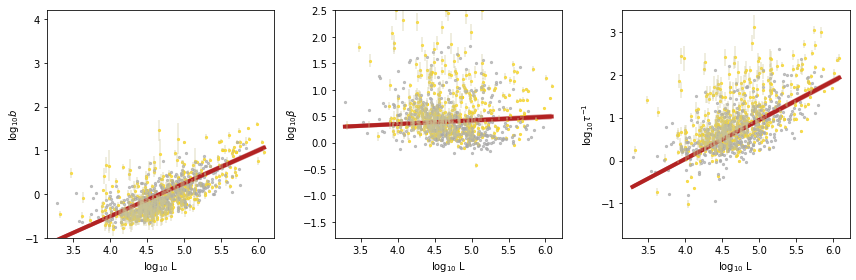

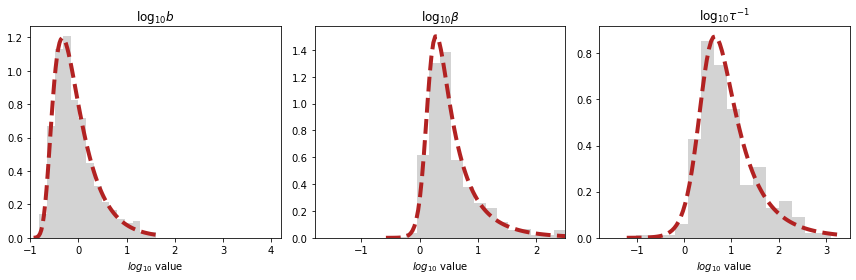

In [33]:
sr_del_arr = []
sd_arr = search_data_arr

for j in range(2):
    sr = load_search_results(result_strings_del[j])
    # sd = load_search_data(search_data_strings[j])
    sd = sd_arr[j]
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()

    print(sr.samp_optimum)
    
    
    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)
    
    sr.plot_gene_distributions(sd,marg='joint')
    
    _=sr.chisquare_testing(sd)
    
    #these do not make sense to do for a single "virtual" grid point
#     sr.resample_opt_viz(sd)
#     sr.resample_opt_mc_viz(sd)
#     sr.chisq_best_param_correction(sd,viz=False) 
#     print(sr.samp_optimum_ind)

    sr.compute_sigma(sd)
    sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
    sr.plot_param_marg()
    
    sr_del_arr.append(sr)

/home/ggorin/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


INFO:root:Figure stored to ./fits/gg_220420_020_nuc_1/analysis_figures/pair_parameter_comparison_12.png.


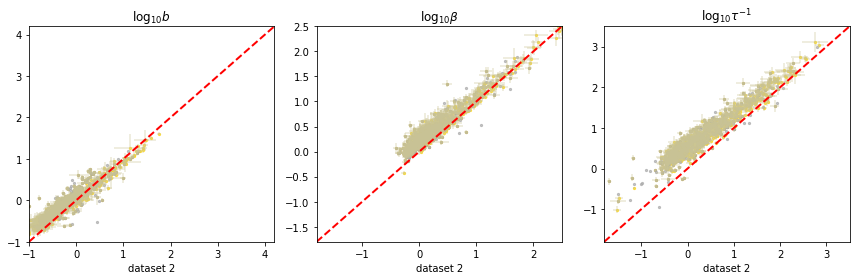

In [34]:
plot_params_for_pair(sr_del_arr[0],sr_del_arr[1],dir_string = dir_string,\
                     distinguish_rej=True,plot_errorbars=True)

Text(0.5, 0, 'Markov model')

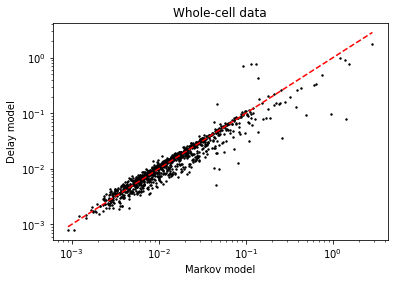

In [38]:
sr1_klds = sr_arr[0].klds[sr_arr[0].samp_optimum_ind]
sr1_del_klds = sr_del_arr[0].klds[sr_del_arr[0].samp_optimum_ind]
plt.scatter(sr1_klds,sr1_del_klds,2,'k')
plt.xscale('log')
plt.yscale('log')
xl = [min(sr1_klds),max(sr1_klds)]
plt.plot(xl,xl,'r--')
plt.title('Whole-cell data')
plt.ylabel('Delay model')
plt.xlabel('Markov model')

Text(0.5, 0, 'Markov model')

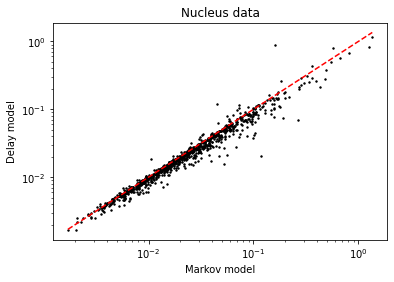

In [36]:
sr2_klds = sr_arr[1].klds[sr_arr[1].samp_optimum_ind]
sr2_del_klds = sr_del_arr[1].klds[sr_del_arr[1].samp_optimum_ind]
plt.scatter(sr2_klds,sr2_del_klds,2,'k')
plt.xscale('log')
plt.yscale('log')
xl = [min(sr2_klds),max(sr2_klds)]
plt.plot(xl,xl,'r--')
plt.title('Nucleus data')
plt.ylabel('Delay model')
plt.xlabel('Markov model')

In [145]:
search_data_strings = ['./fits/gg_220410_020_nuc_2/brain_5k_v3/raw.sd',\
                       './fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/raw.sd']

In [146]:
# search_data = load_search_data(search_data_strings[0])

In [147]:
from cme_toolbox import CMEModel
fitmodel_del = CMEModel('Delay','Poisson')
from inference import InferenceParameters, GradientInference


result_strings_del = []
# search_data_arr_del = []
for j in range(2):
    inference_parameters = InferenceParameters([-1, -1.8, -1.8 ],\
                [4.2, 2.5, 3.5],[-8, -3.5],[-3, 1 ],[15,15],\
                dataset_strings[j],fitmodel_del)
    search_data = load_search_data(search_data_strings[j])
#     search_data_arr_del = extract_data(loom_filepaths[j], transcriptome_filepath, dataset_names[j],
#                         dataset_strings[j], dir_string, dataset_attr_names=attribute_names)
#     search_data_arr.append(search_data)
    full_result_string = inference_parameters.fit_all_grid_points(40,search_data,fitmodel_del)
    result_strings_del.append(full_result_string)

INFO:root:Directory ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15 created.
INFO:root:Global inference parameters stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/parameters.pr.
INFO:root:Search data loaded from ./fits/gg_220410_020_nuc_2/brain_5k_v3/raw.sd.
INFO:root:Starting parallelized grid scan.
DEBUG:root:Grid point 74 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_74.gp.
DEBUG:root:Grid point 22 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_22.gp.
DEBUG:root:Grid point 20 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_20.gp.
DEBUG:root:Grid point 38 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_38.gp.
DEBUG:root:Grid point 44 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_44.gp.
DEBUG:root:Grid point 4 results stored to ./fits/gg_220410_020_nuc

DEBUG:root:Grid point 43 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_43.gp.
DEBUG:root:Grid point 9 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_9.gp.
DEBUG:root:Grid point 25 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_25.gp.
DEBUG:root:Grid point 27 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_27.gp.
DEBUG:root:Grid point 45 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_45.gp.
DEBUG:root:Grid point 11 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_11.gp.
DEBUG:root:Grid point 47 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_47.gp.
DEBUG:root:Grid point 31 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_31.gp.
DEBUG:root:Grid point 13 results stored to

DEBUG:root:Grid point 160 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_160.gp.
DEBUG:root:Grid point 111 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_111.gp.
DEBUG:root:Grid point 120 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_120.gp.
DEBUG:root:Grid point 158 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_158.gp.
DEBUG:root:Grid point 176 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_176.gp.
DEBUG:root:Grid point 105 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_105.gp.
DEBUG:root:Grid point 93 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_93.gp.
DEBUG:root:Grid point 145 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_145.gp.
DEBUG:root:Grid point 127 

DEBUG:root:Grid point 171 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_171.gp.
DEBUG:root:Grid point 212 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_212.gp.
DEBUG:root:Grid point 187 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_187.gp.
DEBUG:root:Grid point 221 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_221.gp.
DEBUG:root:Grid point 203 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_203.gp.
DEBUG:root:Grid point 210 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_210.gp.
DEBUG:root:Grid point 195 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_195.gp.
DEBUG:root:Grid point 153 results stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_point_153.gp.
DEBUG:root:Grid point 13

DEBUG:root:Grid point 12 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_12.gp.
DEBUG:root:Grid point 60 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_60.gp.
DEBUG:root:Grid point 59 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_59.gp.
DEBUG:root:Grid point 71 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_71.gp.
DEBUG:root:Grid point 21 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_21.gp.
DEBUG:root:Grid point 19 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_19.gp.
DEBUG:root:Grid point 5 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_5.gp.
DEBUG:root:Grid point 73 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_73.gp.
DEBUG:root

DEBUG:root:Grid point 126 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_126.gp.
DEBUG:root:Grid point 108 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_108.gp.
DEBUG:root:Grid point 106 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_106.gp.
DEBUG:root:Grid point 89 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_89.gp.
DEBUG:root:Grid point 144 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_144.gp.
DEBUG:root:Grid point 124 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_124.gp.
DEBUG:root:Grid point 122 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_122.gp.
DEBUG:root:Grid point 119 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_11

DEBUG:root:Grid point 170 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_170.gp.
DEBUG:root:Grid point 168 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_168.gp.
DEBUG:root:Grid point 139 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_139.gp.
DEBUG:root:Grid point 186 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_186.gp.
DEBUG:root:Grid point 159 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_159.gp.
DEBUG:root:Grid point 224 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_224.gp.
DEBUG:root:Grid point 209 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_209.gp.
DEBUG:root:Grid point 161 results stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_point_

DEBUG:root:Grid scan results loaded from ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/grid_scan_results.res.
INFO:root:Figure stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/analysis_figures/landscape.png.
(-5.857142857142858, -0.9285714285714284)
INFO:root:Figure stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/analysis_figures/gene_distributions_joint.png.
INFO:root:Original optimum: -5.86, -0.93.


/home/ggorin/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:6707: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp


INFO:root:Chi-square computation complete. Rejected 87 genes out of 1000. Runtime: 0.4 seconds.
INFO:root:New optimum: -5.86, -0.93.
INFO:root:Chi-square computation complete. Rejected 87 genes out of 1000. Runtime: 0.4 seconds.
INFO:root:New optimum: -5.86, -0.93.
INFO:root:Chi-square computation complete. Rejected 87 genes out of 1000. Runtime: 0.4 seconds.
INFO:root:New optimum: -5.86, -0.93.
INFO:root:Chi-square computation complete. Rejected 87 genes out of 1000. Runtime: 0.4 seconds.
INFO:root:New optimum: -5.86, -0.93.
INFO:root:Chi-square computation complete. Rejected 87 genes out of 1000. Runtime: 0.4 seconds.
INFO:root:New optimum: -5.86, -0.93.
INFO:root:Chi-square computation complete. Rejected 87 genes out of 1000. Runtime: 0.4 seconds.
INFO:root:New optimum: -5.86, -0.93.
INFO:root:Chi-square computation complete. Rejected 87 genes out of 1000. Runtime: 0.4 seconds.
INFO:root:New optimum: -5.86, -0.93.
INFO:root:Chi-square computation complete. Rejected 87 genes out of 1

/home/ggorin/projects/seq-cme-technoise/inference.py:470: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index,:] = np.sqrt(np.diag(hess_inv))/np.sqrt(search_data.n_cells)


INFO:root:Figure stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_220410_020_nuc_2/brain_5k_v3/Delay_Poisson_15x15/analysis_figures/parameter_marginals.png.
DEBUG:root:Grid scan results loaded from ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/grid_scan_results.res.
INFO:root:Figure stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/analysis_figures/landscape.png.
(-6.214285714285714, -0.6071428571428568)
INFO:root:Figure stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/analysis_figures/gene_distributions_joint.png.
INFO:root:Original optimum: -6.21, -0.61.


/home/ggorin/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:6707: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp


INFO:root:Chi-square computation complete. Rejected 435 genes out of 1000. Runtime: 0.5 seconds.
INFO:root:New optimum: -5.86, -0.61.
INFO:root:Chi-square computation complete. Rejected 449 genes out of 1000. Runtime: 0.8 seconds.
INFO:root:New optimum: -5.86, -0.61.
INFO:root:Chi-square computation complete. Rejected 449 genes out of 1000. Runtime: 0.5 seconds.
INFO:root:New optimum: -5.86, -0.61.
INFO:root:Chi-square computation complete. Rejected 449 genes out of 1000. Runtime: 0.5 seconds.
INFO:root:New optimum: -5.86, -0.61.
INFO:root:Chi-square computation complete. Rejected 449 genes out of 1000. Runtime: 0.5 seconds.
INFO:root:New optimum: -5.86, -0.61.
INFO:root:Chi-square computation complete. Rejected 449 genes out of 1000. Runtime: 0.5 seconds.
INFO:root:New optimum: -5.86, -0.61.
INFO:root:Chi-square computation complete. Rejected 449 genes out of 1000. Runtime: 0.5 seconds.
INFO:root:New optimum: -5.86, -0.61.
INFO:root:Chi-square computation complete. Rejected 449 genes 

/home/ggorin/projects/seq-cme-technoise/inference.py:470: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index,:] = np.sqrt(np.diag(hess_inv))/np.sqrt(search_data.n_cells)


INFO:root:Figure stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_220410_020_nuc_2/brain_nuc_5k_v3/Delay_Poisson_15x15/analysis_figures/parameter_marginals.png.


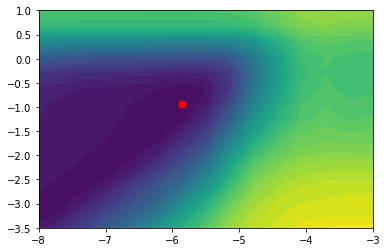

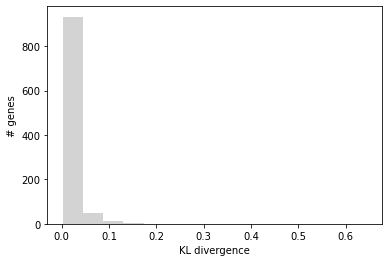

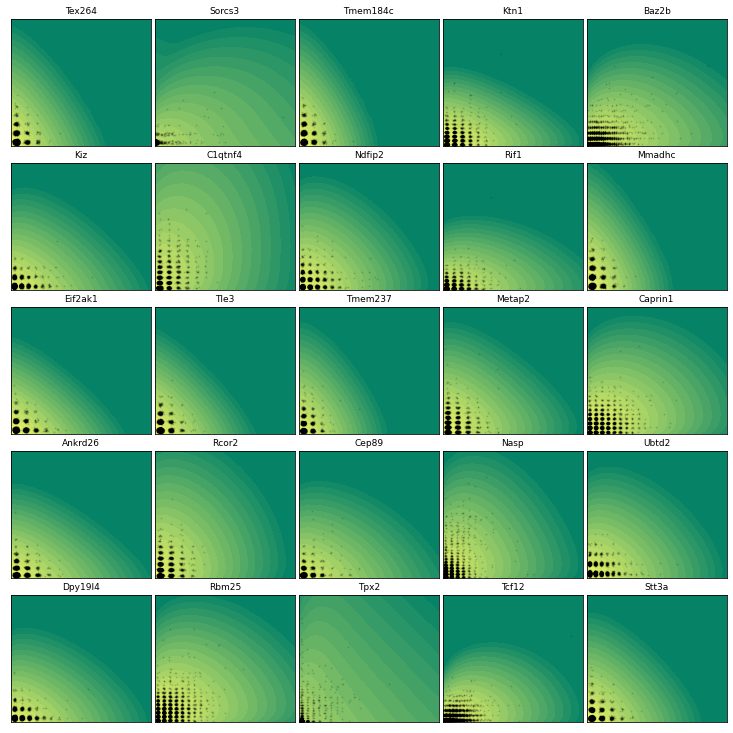

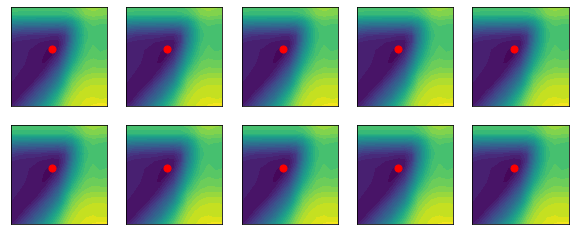

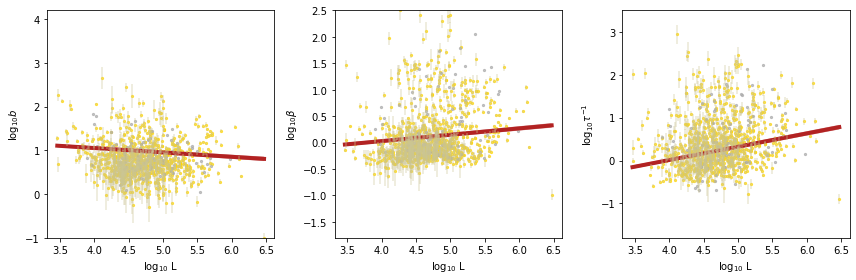

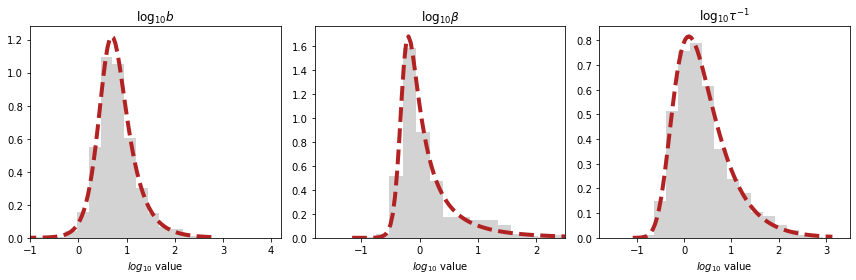

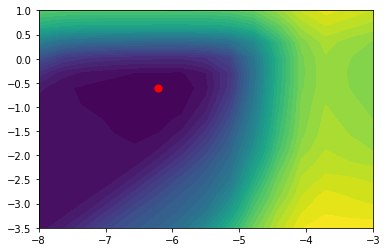

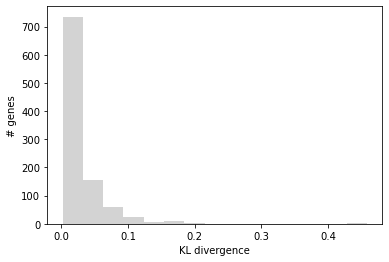

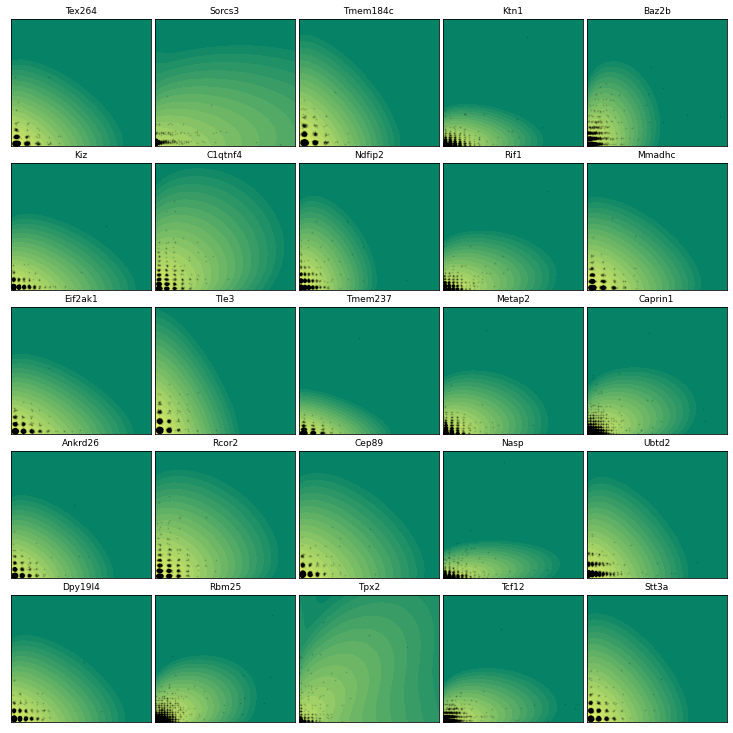

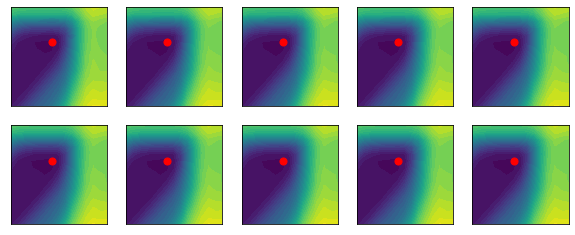

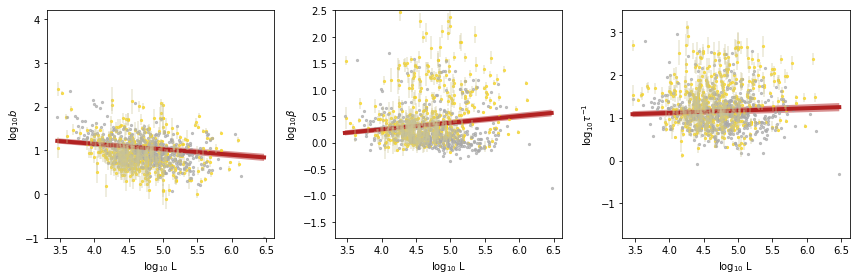

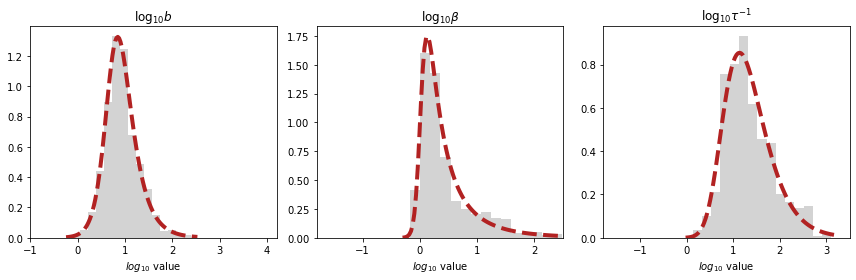

In [148]:
sr_del_arr = []
sd_arr = search_data_arr

for j in range(2):
    sr = load_search_results(result_strings_del[j])
    # sd = load_search_data(search_data_strings[j])
    sd = sd_arr[j]
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    sr.plot_landscape(ax1,savefig=True)
    print(sr.samp_optimum)
#     plot_param_L_dep(sr,sd)
    
    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)
    
    plot_gene_distributions(sr,sd,marg='joint')
    
#     _=sr.chisquare_testing(sd)
    
    
#     sr.resample_opt_viz(sd)
    
#     sr.resample_opt_mc_viz(sd)
    sr.chisq_best_param_correction(sd)
    print(sr.samp_optimum_ind)
    sr.compute_sigma(sd)
    plot_param_L_dep(sr,sd,plot_errorbars=True,plot_fit=True)
    sr.plot_param_marg()
    
    sr_del_arr.append(sr)

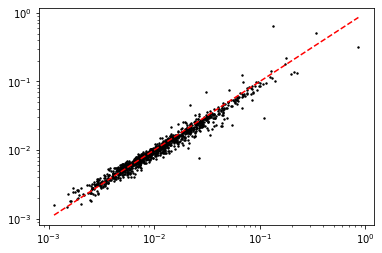

In [167]:
sr1_klds = sr_arr[0].klds[sr_arr[0].samp_optimum_ind]
sr1_del_klds = sr_del_arr[0].klds[sr_del_arr[0].samp_optimum_ind]
plt.scatter(sr1_klds,sr1_del_klds,2,'k')
plt.xscale('log')
plt.yscale('log')
xl = [min(sr1_klds),max(sr1_klds)]
plt.plot(xl,xl,'r--')


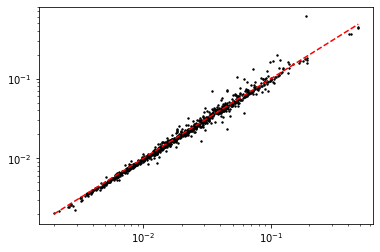

In [168]:
sr2_klds = sr_arr[1].klds[sr_arr[1].samp_optimum_ind]
sr2_del_klds = sr_del_arr[1].klds[sr_del_arr[1].samp_optimum_ind]
plt.scatter(sr2_klds,sr2_del_klds,2,'k')
plt.xscale('log')
plt.yscale('log')
xl = [min(sr2_klds),max(sr2_klds)]
plt.plot(xl,xl,'r--')

INFO:root:Figure stored to ./fits/gg_220410_020_nuc_1/brain_nuc_5k_v3/Delay_Poisson_15x15/analysis_figures/length_dependence.png.


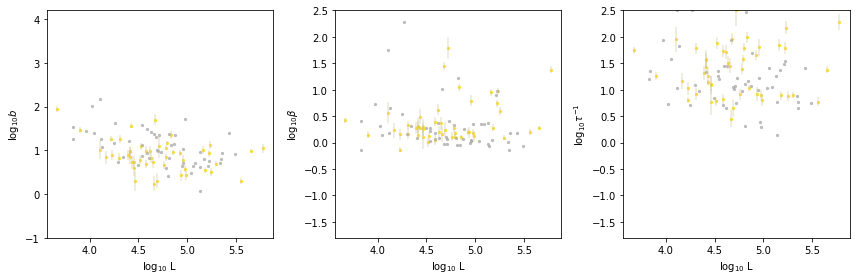

In [129]:
plot_param_L_dep(sr,sd,plot_errorbars=True,plot_fit=False,distinguish_rej=True)

In [120]:
# def plot_param_L_dep_(search_results,search_data,gene_filter = None,\
#                      plot_errorbars=False,\
#                      figsize=(12,4),c=2.576,\
#                      axis_search_bounds = True, plot_fit = False,\
#                      distinguish_rej = True):
#     fig1,ax1=plt.subplots(nrows=1,ncols=3,figsize=figsize)

#     if gene_filter is None:
#         gene_filter = np.ones(search_results.phys_optimum.shape[0],dtype=bool)
#         gene_filter_rej = np.zeros(search_results.phys_optimum.shape[0],dtype=bool)
#     else:
#         if gene_filter.dtype != np.bool:
#             gf_temp = np.zeros(search_results.phys_optimum.shape[0],dtype=bool)
#             gf_temp[gene_filter] = True
#             gene_filter = gf_temp
#             gene_filter_rej = np.zeros(search_results.phys_optimum.shape[0],dtype=bool) #something like this...

#     if distinguish_rej: #default
#         if hasattr(search_results,'rejected_genes'):
#             if search_results.rejection_index != search_results.samp_optimum_ind:
#                 log.warning('Sampling parameter value is inconsistent.')
#                 distinguish_rej = False
#             else: #if everything is ready
#                 gene_filter_rej =  np.logical_and(gene_filter,search_results.rejected_genes)
#                 gene_filter = np.logical_and(gene_filter,~search_results.rejected_genes)
#                 acc_point_aesth = ('accepted_gene_color','accepted_gene_alpha','accepted_gene_ms')
#                 rej_point_aesth = ('rejected_gene_color','rejected_gene_alpha','rejected_gene_ms')
#         else:
#             log.info('Gene rejection needs to be precomputed to distinguish rejected points.')
#             distinguish_rej = False

#     if not distinguish_rej: #don't distinguish
#         acc_point_aesth = ('generic_gene_color','generic_gene_alpha','generic_gene_ms')
#         # gene_filter = np.ones(search_results.phys_optimum.shape[0],dtype=bool)
#         log.info('Falling back on generic marker properties.') 

#     for i in range(3):
#         if plot_errorbars:
#             # raise ValueError('I still need to implement this.')

#             lfun = lambda x,a,b: a*x+b
#             if plot_fit:
# 	            popt,pcov = scipy.optimize.curve_fit(lfun,search_data.gene_log_lengths[gene_filter],
# 	                                                 search_results.phys_optimum[gene_filter,i],\
#                                                      sigma=search_results.sigma[gene_filter,i],
# 	                                                 absolute_sigma=True)
# 	            xl = np.array([min(search_data.gene_log_lengths),max(search_data.gene_log_lengths)])

# 	            min_param = (popt[0]-np.sqrt(pcov[0,0])*c,popt[1]-np.sqrt(pcov[1,1])*c)
# 	            max_param = (popt[0]+np.sqrt(pcov[0,0])*c,popt[1]+np.sqrt(pcov[1,1])*c)
# 	            ax1[i].fill_between(xl,\
# 	            	lfun(xl,min_param[0],min_param[1]),\
# 	            	lfun(xl,max_param[0],max_param[1]),\
# 	            	facecolor=aesthetics['length_fit_face_color'],\
# 	            	alpha=aesthetics['length_fit_face_alpha'])
# 	            ax1[i].plot(xl,lfun(xl,popt[0],popt[1]),\
# 	            	c=aesthetics['length_fit_line_color'],\
# 	            	linewidth=aesthetics['length_fit_lw'])
#             ax1[i].errorbar(search_data.gene_log_lengths[gene_filter],
#                             search_results.phys_optimum[gene_filter,i],
#                             search_results.sigma[gene_filter,i]*c,c=aesthetics['errorbar_gene_color'],
#                             alpha=aesthetics['errorbar_gene_alpha'],linestyle='None',
#                             linewidth = aesthetics['errorbar_lw'])

#         ax1[i].scatter(search_data.gene_log_lengths[gene_filter],
#                         search_results.phys_optimum[gene_filter,i],\
#                        c=aesthetics[acc_point_aesth[0]],\
#                        alpha=aesthetics[acc_point_aesth[1]],\
#                        s=aesthetics[acc_point_aesth[2]])

#         if np.any(gene_filter_rej):
#             ax1[i].scatter(search_data.gene_log_lengths[gene_filter_rej],
#                 search_results.phys_optimum[gene_filter_rej,i],\
#                c=aesthetics[rej_point_aesth[0]],\
#                alpha=aesthetics[rej_point_aesth[1]],\
#                s=aesthetics[rej_point_aesth[2]])

#         ax1[i].set_xlabel(r'$\log_{10}$ L')
#         ax1[i].set_ylabel(search_results.model.get_log_name_str()[i])
#         if axis_search_bounds:
#             ax1[i].set_ylim([search_results.phys_lb[i],search_results.phys_ub[i]])
#     fig1.tight_layout()
#     fig_string = search_results.analysis_figure_string+'/length_dependence.png'
#     plt.savefig(fig_string)
#     log.info('Figure stored to {}.'.format(fig_string))

In [98]:
gene_filter = np.ones(sr.phys_optimum.shape[0],dtype=bool)

In [99]:
np.logical_and(gene_filter,~sr.rejected_genes)

array([ True,  True,  True, False, False, False,  True, False, False,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
       False,  True,  True,  True, False, False,  True,  True, False,
        True,  True, False,  True,  True, False, False,  True, False,
        True, False, False,  True,  True, False,  True, False, False,
        True, False,  True, False, False,  True,  True,  True, False,
       False,  True, False, False,  True, False, False,  True,  True,
       False, False, False, False,  True, False,  True, False, False,
       False,  True, False, False, False,  True, False, False, False,
        True, False, False, False, False, False,  True,  True,  True,
        True])

In [101]:
np.logical_and(gene_filter,sr.rejected_genes)

array([False, False, False,  True,  True,  True, False,  True,  True,
       False, False, False,  True,  True,  True,  True, False, False,
       False, False, False,  True, False,  True, False, False, False,
        True, False, False, False,  True,  True, False, False,  True,
       False, False,  True, False, False,  True,  True, False,  True,
       False,  True,  True, False, False,  True, False,  True,  True,
       False,  True, False,  True,  True, False, False, False,  True,
        True, False,  True,  True, False,  True,  True, False, False,
        True,  True,  True,  True, False,  True, False,  True,  True,
        True, False,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False, False, False,
       False])

In [102]:
aesthetics

{'generic_gene_color': 'dimgray',
 'accepted_gene_color': 'gold',
 'rejected_gene_color': 'darkgrey',
 'generic_gene_alpha': 0.5,
 'accepted_gene_alpha': 0.7,
 'rejected_gene_alpha': 0.7,
 'generic_gene_ms': 10,
 'accepted_gene_ms': 5,
 'rejected_gene_ms': 5,
 'hist_face_color': 'lightgray',
 'hist_fit_color': 'firebrick',
 'hist_fit_lw': 4,
 'errorbar_gene_color': [0.796078431372549,
  0.7725490196078432,
  0.5843137254901961],
 'errorbar_gene_alpha': 0.3,
 'errorbar_lw': 2,
 'length_fit_line_color': 'firebrick',
 'length_fit_face_color': 'firebrick',
 'length_fit_face_alpha': 0.5,
 'length_fit_lw': 4}

In [45]:
# def plot_params_for_pair(sr1,sd1,sr2,gene_filter = None,\
#                      plot_errorbars=False,\
#                      figsize=(12,4),c=2.576,\
#                      axis_search_bounds = True,
#                      distinguish_rej = True,
#                      plot_identity = True):
#     fig1,ax1=plt.subplots(nrows=1,ncols=3,figsize=figsize)

#     if gene_filter is None:
#         gene_filter = np.ones(sr1.phys_optimum.shape[0],dtype=bool)
#         gene_filter_rej = ~gene_filter
#     else:
#         if gene_filter.dtype != np.bool:
#             gf_temp = np.zeros(sr1.phys_optimum.shape[0],dtype=bool)
#             gf_temp[gene_filter] = True
#             gene_filter = gf_temp
#             gene_filter_rej = np.zeros(search_results.phys_optimum.shape[0],dtype=bool) #something like this...

#     if distinguish_rej: #default
#         if hasattr(sr1,'rejected_genes') and hasattr(sr2,'rejected_genes'):
#             if sr1.rejection_index != sr1.samp_optimum_ind:
#                 log.warning('Sampling parameter value is inconsistent.')
#                 distinguish_rej = False
#             elif sr2.rejection_index != sr2.samp_optimum_ind:
#                 log.warning('Sampling parameter value is inconsistent.')
#                 distinguish_rej = False
#             else: #if everything is ready
#                 gene_filter = np.logical_and(gene_filter,~sr1.rejected_genes,~sr2.rejected_genes)
#                 gene_filter_rej =  np.logical_and(gene_filter,np.logical_or(sr1.rejected_genes,sr2.rejected_genes))
#                 acc_point_aesth = ('accepted_gene_color','accepted_gene_alpha','accepted_gene_ms')
#                 rej_point_aesth = ('rejected_gene_color','rejected_gene_alpha','rejected_gene_ms')
#         else:
#             log.info('Gene rejection needs to be precomputed to distinguish rejected points.')
#             distinguish_rej = False

#     if not distinguish_rej: #don't distinguish
#         acc_point_aesth = ('generic_gene_color','generic_gene_alpha','generic_gene_ms')
#         log.info('Falling back on generic marker properties.') 

#     for i in range(3):
#         if plot_errorbars:
#             ax1[i].errorbar(sr1.phys_optimum[gene_filter,i],\
#                             sr2.phys_optimum[gene_filter,i],\
#                             sr1.sigma[gene_filter,i]*c,\
#                             sr2.sigma[gene_filter,i]*c,\
#                             c=aesthetics['errorbar_gene_color'],
#                             alpha=aesthetics['errorbar_gene_alpha'],\
#                             linestyle='None',
#                             linewidth = aesthetics['errorbar_lw'])
#         ax1[i].scatter(sr1.phys_optimum[gene_filter,i],
#                        sr2.phys_optimum[gene_filter,i],\
#                        c=aesthetics[acc_point_aesth[0]],\
#                        alpha=aesthetics[acc_point_aesth[1]],\
#                        s=aesthetics[acc_point_aesth[2]])
#         if np.any(gene_filter_rej):
#             ax1[i].scatter(sr1.phys_optimum[gene_filter_rej,i],
#                            sr2.phys_optimum[gene_filter_rej,i],\
#                c=aesthetics[rej_point_aesth[0]],\
#                alpha=aesthetics[rej_point_aesth[1]],\
#                s=aesthetics[rej_point_aesth[2]])

#         ax1[i].set_xlabel(r'dataset 1')
#         ax1[i].set_xlabel(r'dataset 2')
#         ax1[i].set_title(sr1.model.get_log_name_str()[i])
#         if axis_search_bounds:
#             ax1[i].set_xlim([sr1.phys_lb[i],sr1.phys_ub[i]])
#             ax1[i].set_ylim([sr1.phys_lb[i],sr1.phys_ub[i]])
#         if plot_identity:
#             xl = ax1[i].get_xlim()
#             ax1[i].plot(xl,xl,'r--',linewidth=2)
#     fig1.tight_layout()
#     fig_string = dir_string+'/analysis_figures/comparison.png'
#     plt.savefig(fig_string)
#     log.info('Figure stored to {}.'.format(fig_string))

/home/ggorin/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [190]:
# plot_params_for_pair(sr_arr[0],sd_arr[0],sr_arr[1],distinguish_rej=True,plot_errorbars=True)

In [191]:
# # you can do this but it looks like trash
# def find_most_concordant_samp(sr1,sr2):
#     discordance = ((sr1.param_estimates - sr2.param_estimates)**2).sum(2).sum(1)
#     srt =  np.argsort(discordance)
#     samp_concordant_ind = srt[0]
#     sr1.set_sampling_optimum(samp_concordant_ind)
#     sr2.set_sampling_optimum(samp_concordant_ind)

#     log.info('Optimum set to at {:.2f}, {:.2f}.'.format(sr1.samp_optimum[0],sr1.samp_optimum[1]))
#     return sr1.samp_optimum

INFO:root:Figure stored to ./fits/gg_220410_020_batch_1/analysis_figures/pair_parameter_comparison.png.


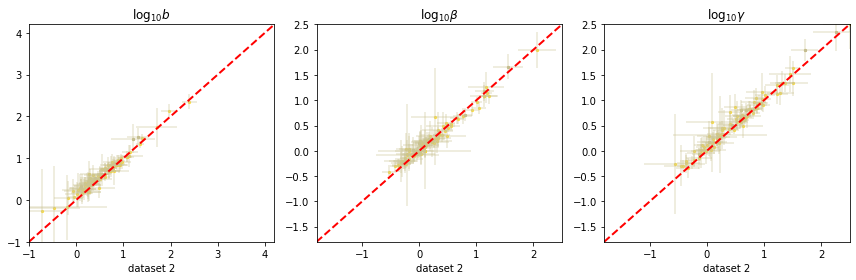

In [54]:
# find_most_concordant_samp(sr_arr[0],sr_arr[1])
plot_params_for_pair(sr_arr[0],sd_arr[0],sr_arr[1],analysis_dir_string='./fits/gg_220410_020_batch_1/analysis_figures',\
                     distinguish_rej=True,plot_errorbars=True)

In [180]:
# aesthetics['errorbar_gene_color']

In [ ]:
x = zip(range(inference_parameters.n_grid_points),[[search_data,fitmodel]]*inference_parameters.n_grid_points)

In [ ]:
import pickle


In [ ]:
grid_point_result_string = './gg_220409_020_batch_1/pbmc_1k_fbc/Bursty_Poisson_2x2/grid_point_0.gp'
with open(grid_point_result_string,'rb') as ipfs:
    grid_point_results = pickle.load(ipfs)
# grid_point_results = pickle.load('./gg_220409_020_batch_1/pbmc_1k_fbc/Bursty_Poisson_3x3/grid_point_0.gp')

In [ ]:

for y in x:
    point_index,[sd,model]= y
    break

In [ ]:
point_index

0

In [ ]:
grad_inference = GradientInference(inference_parameters,search_data,fitmodel,0)

In [ ]:
grad_inference.fit_all_genes(fitmodel,search_data)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


DEBUG:root:Grid point 0 results stored to ./gg_220409_020_batch_1/pbmc_1k_fbc/grid_point_0.


In [ ]:
grad_inference.param_MoM[:10]

In [ ]:
param_estimates[:10]

In [ ]:
transcriptome_dict = get_transcriptome(transcriptome_filepath)

In [ ]:
j=0
_,_,names,_ = import_vlm(loom_filepaths[j],*attribute_names[j])

In [ ]:
names

array(['DDX11L1', 'WASH7P', 'MIR6859-1', ..., 'AC007325.1', 'AC007325.4',
       'AC007325.2'], dtype=object)

In [ ]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.warning('I print to stderr by default')
log.debug('A debug message!')
log.info('We processed %d records', 20)


DEBUG:root:A debug message!
INFO:root:We processed 20 records


In [ ]:
import logging
logger = logging.getLogger()
logging.debug("test")


DEBUG:root:test


In this notebook, we illustrate a Markov chain approach for joint probabilistic description of technical and biological noise in scRNA-seq.

We implement a [conventional two-stage model](https://www.sciencedirect.com/science/article/pii/S0006349512007904?via%3Dihub) for the living cell dynamics. Unspliced mRNA transcripts are produced in geometric bursts. These unspliced transcripts are spliced, then degraded. After equilibration, the sequencing process starts, halting all biological processes. The cDNA library construction is a pure-birth process: it yields $Poisson(\lambda_u)$ *in silico* UMIs for each unspliced mRNA and $Poisson(\lambda_s)$ UMIs for each spliced mRNA.

We use a length-dependent model of UMI capture. Specifically, we posit that $\lambda_u = C_u L$, where $L$ is the length of the full gene: longer genes have more poly(A) stretches that can be captured by the oligo(dT) primers used in scRNA-seq. On the other hand, $\lambda_s$ is presumed constant across all genes: spliced transcripts are primarily captured at the poly(A) tail appended before nuclear export.

We scan over a grid of $\{C_u, \lambda_s\}$ values, compute the conditional maximum likelihood estimates for the biological parameters, identify a sampling parameter optimum, and investigate parameter trends and fit quality. 

In [ ]:
from datetime import date
import time
t1 = time.time()

## Prerequisites

First, install the necessary numerical differentiation, parallelization, and `loom` file import packages.

In [ ]:
!pip -q install numdifftools 
!pip -q install parfor
!pip -q install loompy

     |████████████████████████████████| 99 kB 2.8 MB/s 
     |████████████████████████████████| 189 kB 17.0 MB/s 
     |████████████████████████████████| 4.8 MB 5.1 MB/s 
     |████████████████████████████████| 48 kB 4.7 MB/s 


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Clone the project GitHub repository to collect the data and processing scripts. The [10X](https://figshare.com/articles/dataset/10X_protein_and_mRNA_counts/9912734/1?file=17820449) dataset was processed using `kb` for the [protein velocity article](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1945-3), collected from Figshare, and uploaded to Github.

In [ ]:
!rm -r *

In [ ]:
!git clone --branch dev https://github.com/gennadygorin/seq-cme-technoise

Cloning into 'seq-cme-technoise'...
remote: Enumerating objects: 407, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 407 (delta 127), reused 148 (delta 74), pack-reused 199
Receiving objects: 100% (407/407), 53.58 MiB | 20.91 MiB/s, done.
Resolving deltas: 100% (191/191), done.


In [ ]:
# !git branch -a

In [ ]:
!mv seq-cme-technoise/* .
!mv polyA_ref/* .


Import the processing scripts.

In [ ]:
from cme_toolbox import *

In [ ]:
model = CMEModel(bio_model='Delay',seq_model='Bernoulli',quad_method='quad_vec')

In [ ]:
p = np.asarray([1,0.5,0.2])
limits = np.asarray([20,20])
# samp = np.asarray([-1.0,-1.0])
samp = np.asarray([0.9,0.2])

In [ ]:
P = model.eval_model_pss(p,limits,samp)

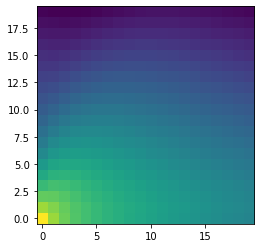

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(np.log10(P).T)
plt.gca().invert_yaxis()

## Inference

The implementation has a driver function. The driver is intended to be run from the command line, and pointed to an input script that defines the search parameters. If the driver is run in notebook, it outputs figures with gene count summaries.

The driver inputs a text file with parameters. The most salient ones are:


* `loom_filenames`: which `loom` files to fit? If multiple dataset names are listed, the process collects genes that are retained after filtering in *all* datasets. The specific file to analyze is indicated by the zero-indexed entry `IND`.
* `phys_lb` and `phys_ub`: what are the lower and upper bounds on $\log_{10}$ of the physical parameters $b$, $\beta$, and $\gamma$ = burst size, splicing rate, and degradation rate? Note that the rates are normalized to burst frequency $k_i$.
* `samp_lb` and `samp_ub`: what are the lower and upper bounds on $\log_{10}$ of the sampling parameters $C_u$ and $\lambda_s$? These parameters are scanned on a grid of dimensions `n_pt1`$\times$`n_pt2`.


In [ ]:
!cat loom_fbc/example_input.txt

#Parameter input for CME inference 
dataset_directory : ./loom_fbc/ : folder with dataset loom files
result_directory : ./ : where to put the result folder
loom_filenames : pbmc_1k_fbc : filenames to integrate
transcriptome_filename : gg_200525_genome_polyA_cum_3 : transcriptome location
polyA_threshold : 15 : minimum polyA count to use for sampling function
transcriptome_ind : 0 : column of transcriptome file to use (lengths if 0, polyA count if 1)
filter_param : 0.01, 0.01, 350, 350, 3, 3 : min threshold for mean, max threshold for max, mean threshold for max; odd is U, even is S
all_prev_results : : result files with gene names to exclude
attribute_names : [['spliced','unspliced','Gene','CellID']]*2 : list or list of lists with loom attribute names
gene_sel_seed : 123 : gene selection seed
n_gen : 100 : number of genes to select
IND : 0 : loom_filename to analyze
gene_list : : set of result files to import to define gene names
phys_lb : -1, -1.8, -1.8 : log10 of lower bound on burst

Run the inference workflow. This will input the `loom` file, select genes with moderate expression (dark gray in second figure), and select a subset of those to fit (blue in second figure).

Each run creates a directory with the date and metadata (dataset name, grid size, number of genes). Some metadata can be defined in the input text file. The grid scan runs in parallel. The procedure is stable for searches with a lot of genes and grid points: if the algorithm halts, the intermediate results are stored.

The directory contains files for each grid point, a `metadata` file that defines the search parameters, a `nosamp` file with results for the noise-free fit, and a `result` file that bundles all results together and can be imported for further analysis.

['./loom_fbc/pbmc_1k_fbc.loom']
Beginning preprocessing routine:
Dataset: ./loom_fbc/pbmc_1k_fbc.loom
64792 features observed, 55712 match genome annotations. 52809 are unique. 
1305 cells detected.
24426 genes retained as high-expression.
2684 genes retained in loom structure based on filter.
Gene set size: 2684
-----------
100 genes selected.
Gene set selected!
Beginning search routine.
64792 features observed, 55712 match genome annotations. 52809 are unique. 
1305 cells detected.
Directory ./gg_220406_pbmc_1k_fbc_5x6_100gen_1 created; metadata written.
30 of 30 points to be evaluated.
Starting search...


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


Parallelization done!


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


Runtime: 1.6 min.


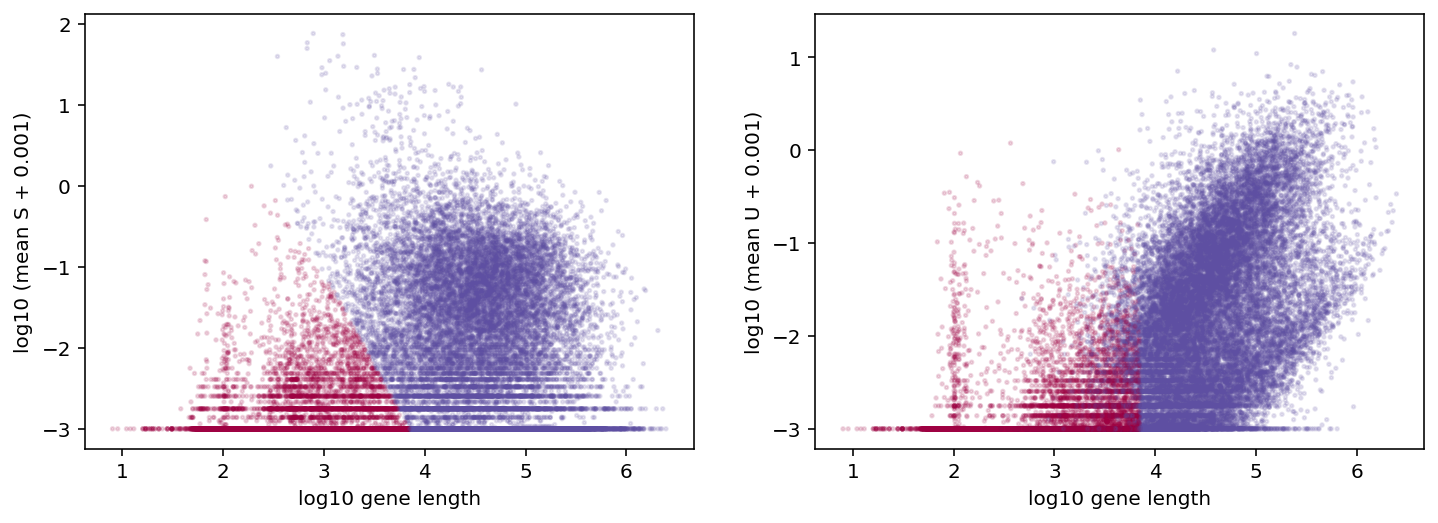

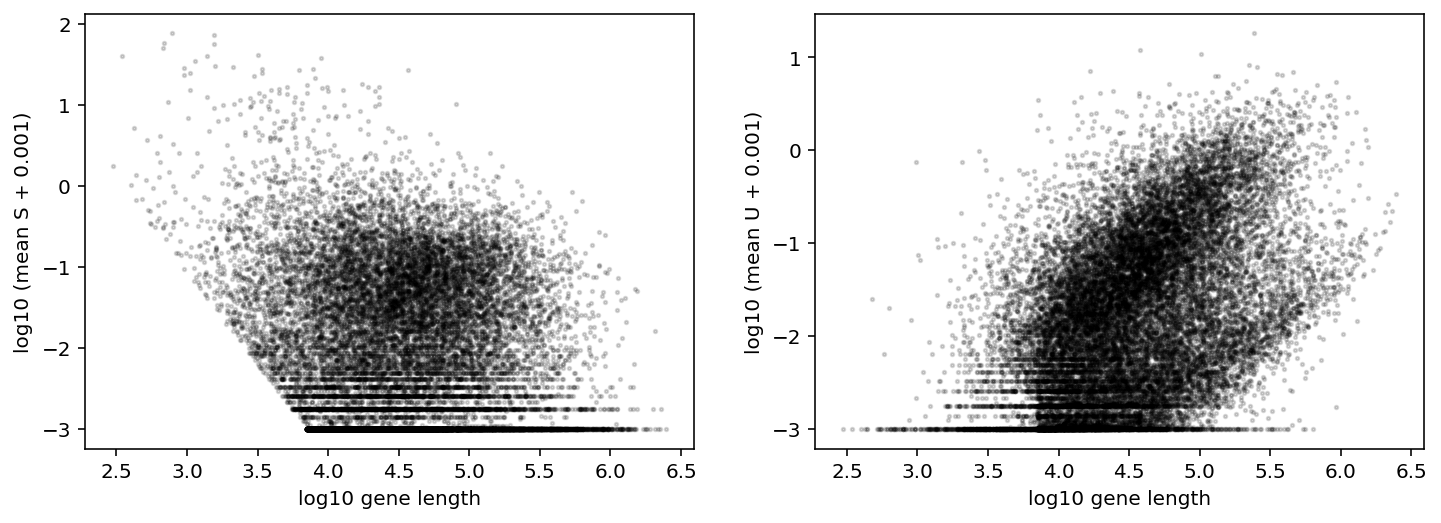

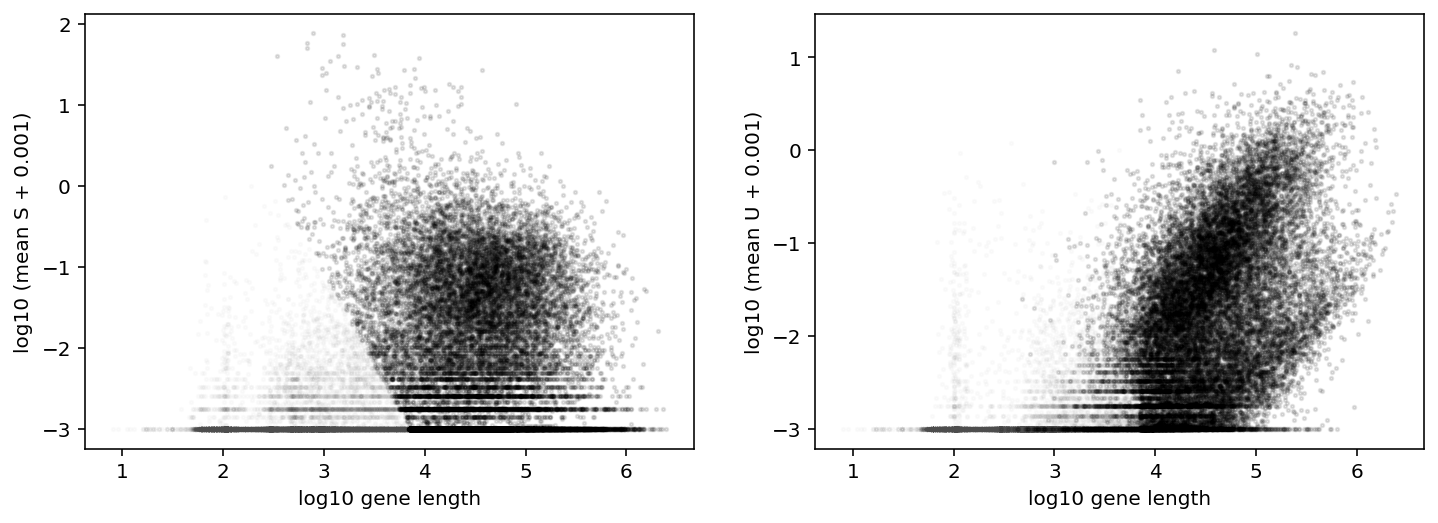

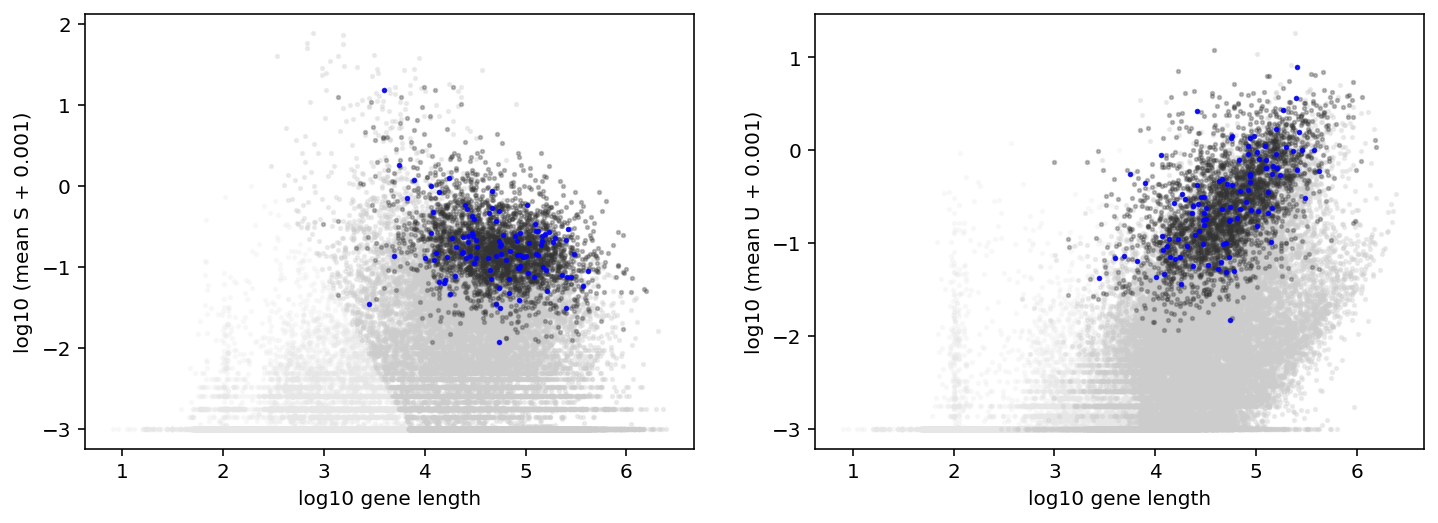

In [ ]:
inference_workflow('loom_fbc/example_input.txt')

## Result processing

### Data summary and exploration

Import the results. This interface can accept multiple inputs: for example, it's possible to use the same grid for searches over several sets of genes and integrate them in downstream analysis. The names of the strings in the list should be in the format `./result_dir/result.pickle`. 

In [ ]:
result_data = import_datasets(['./gg_{}_pbmc_1k_fbc_5x6_100gen_1/result.pickle'.format(date.today().strftime("%y%m%d"))])

Visualize the sampling parameter landscape. There is clearly an optimal basin in the $C_u, \lambda_s$ space, although the low resolution of the scan and the  number of genes make it challenging to identify it with much confidence.

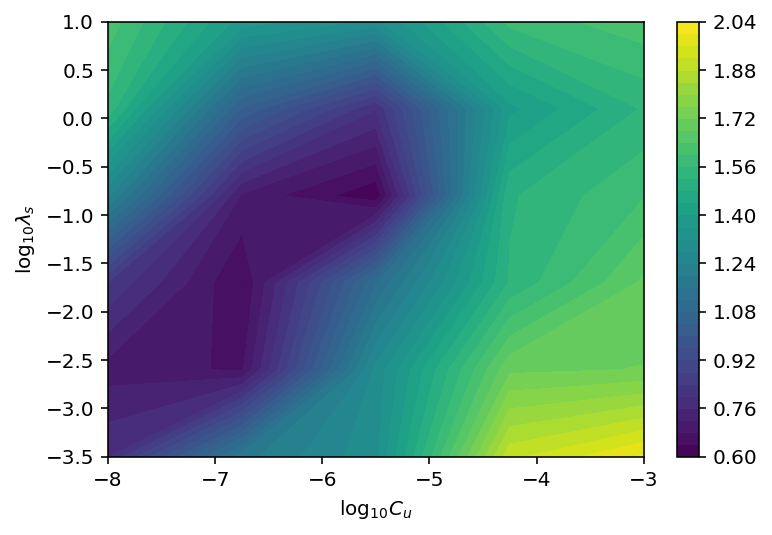

In [ ]:
landscape_viz(result_data)

Compute the best parameter tuple using simple total KL divergence minimization. 

In [ ]:
result_data.find_best_params()

In [ ]:
result_data.best_samp_params

(-5.5, -0.7999999999999998)

Test the stability of the parameter optimum under resampling. Essentially, we subsample sets of genes and see how the landscape and its optimum change. The basin appears to be robust and well-defined with as few as 20 genes.

In [ ]:
resamp_vec = np.array(np.linspace(0,result_data.n_gen,6)[1:-1],dtype=int)

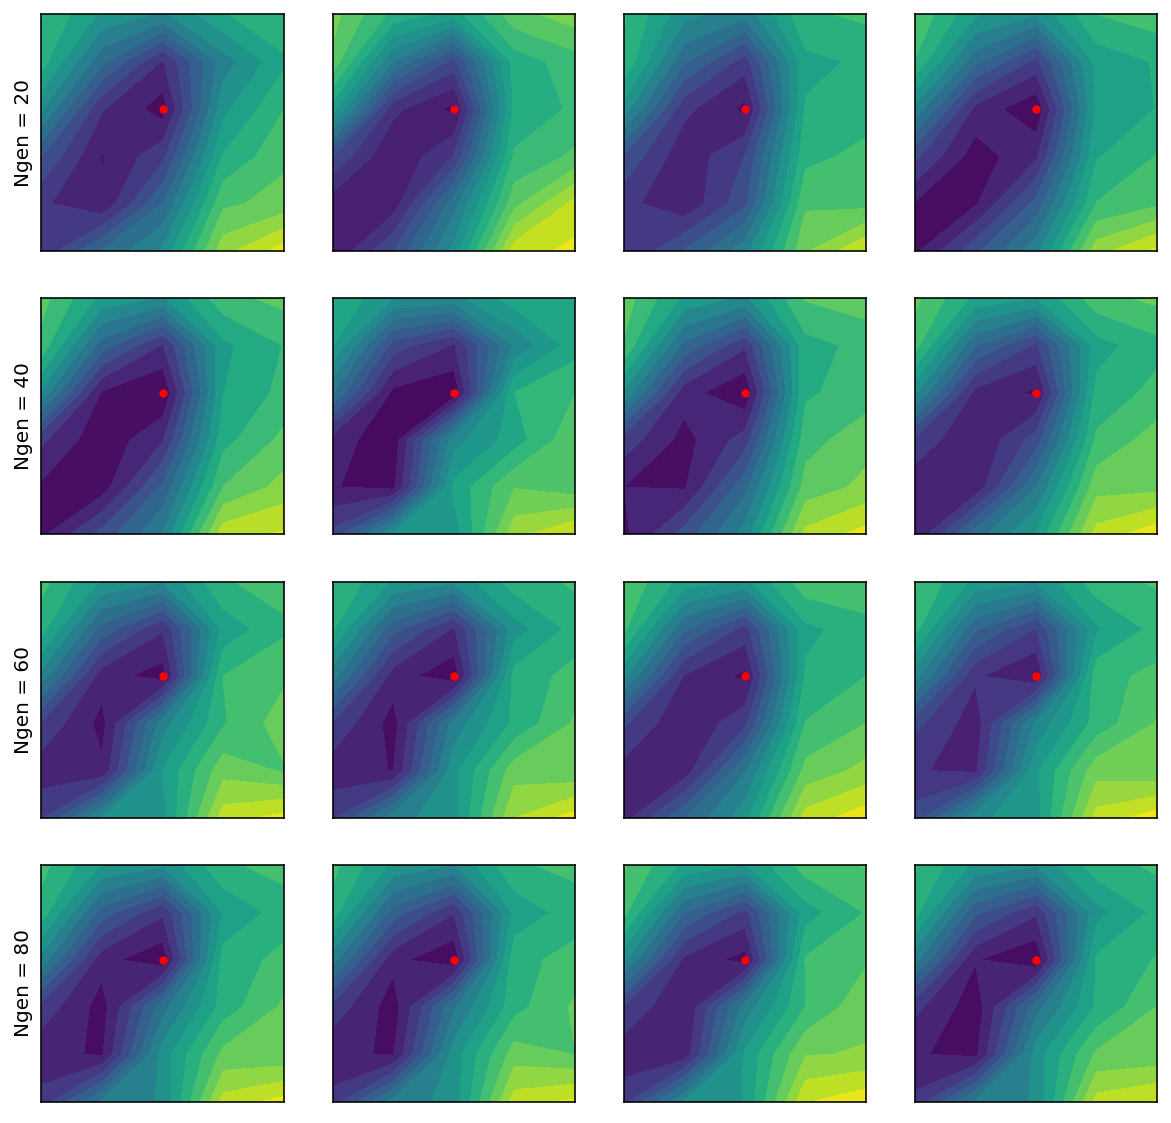

In [ ]:
resample_opt_viz(result_data,resamp_vec)

Summarize these findings by resampling 1000 times and plotting the locations of the optima.

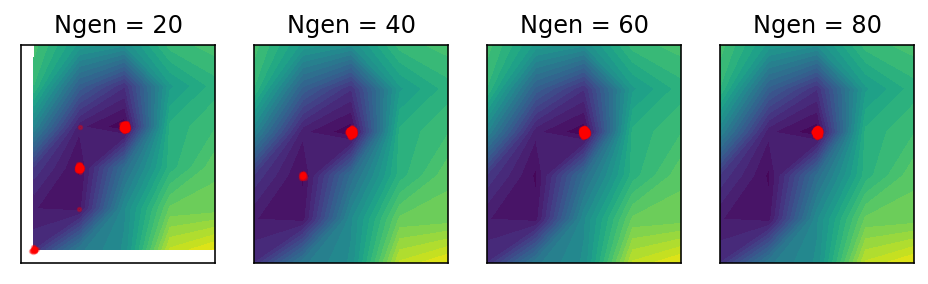

In [ ]:
resample_opt_mc_viz(result_data,resamp_vec)

Plot a normal-inverse Gaussian fit to the parameters, with and without sampling. The parameters clearly show quite a bit of skewness.

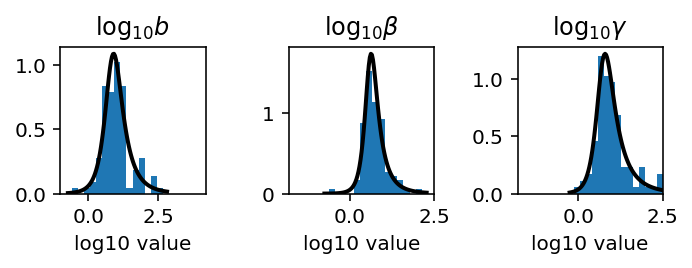

In [ ]:
from scipy.stats import *
plot_param_marg(result_data,fitlaw=norminvgauss)

Perform the same analysis on the noise-free results. The burst size parameters are shifted down by roughly an order of magnitude.

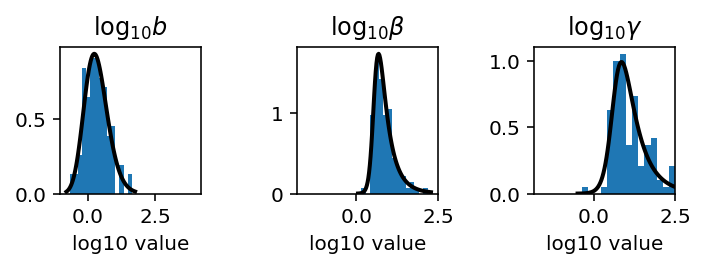

In [ ]:
plot_param_marg(result_data,nosamp=True,fitlaw=norminvgauss)

Examine length dependence (without error bars on maximum likelihood estimates). The full technical noise model does not appear to show much length dependence -- apart from, perhaps, a very modest decrease in burst size. The noise-free model shows that the burst size increases with length.

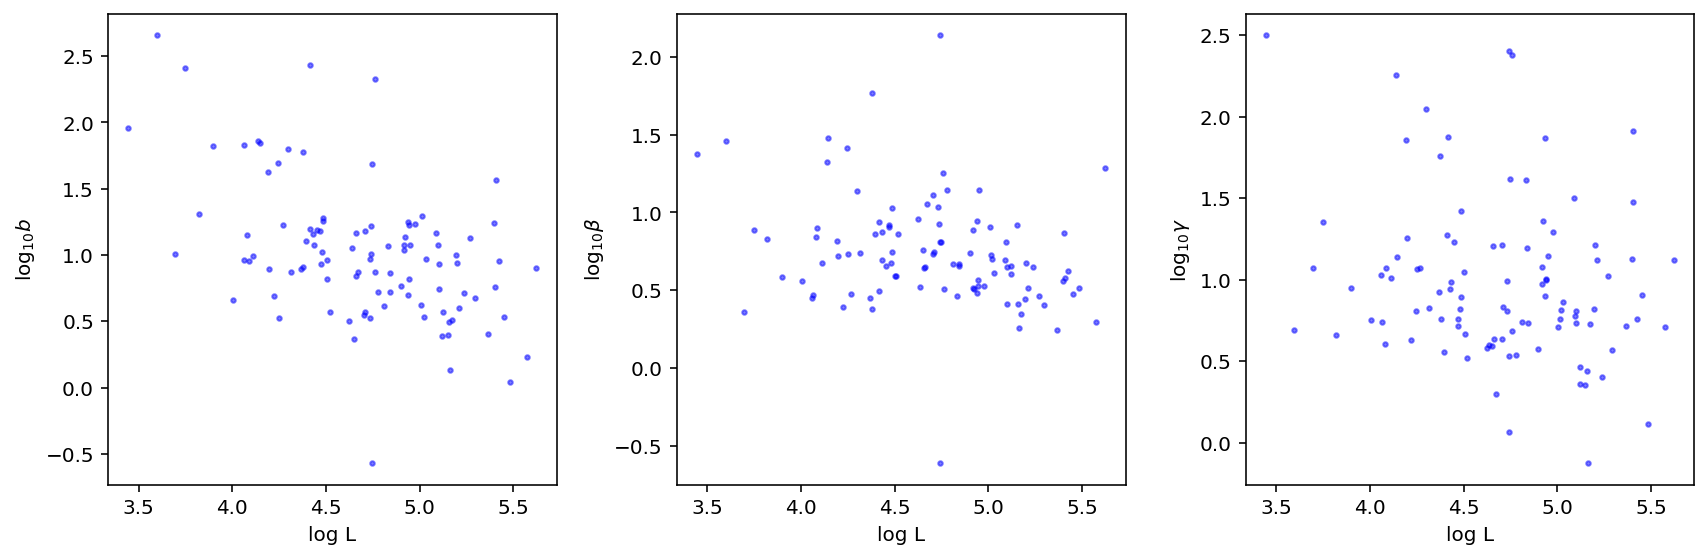

In [ ]:
plot_param_L_dep(result_data,plot_errorbars=False)

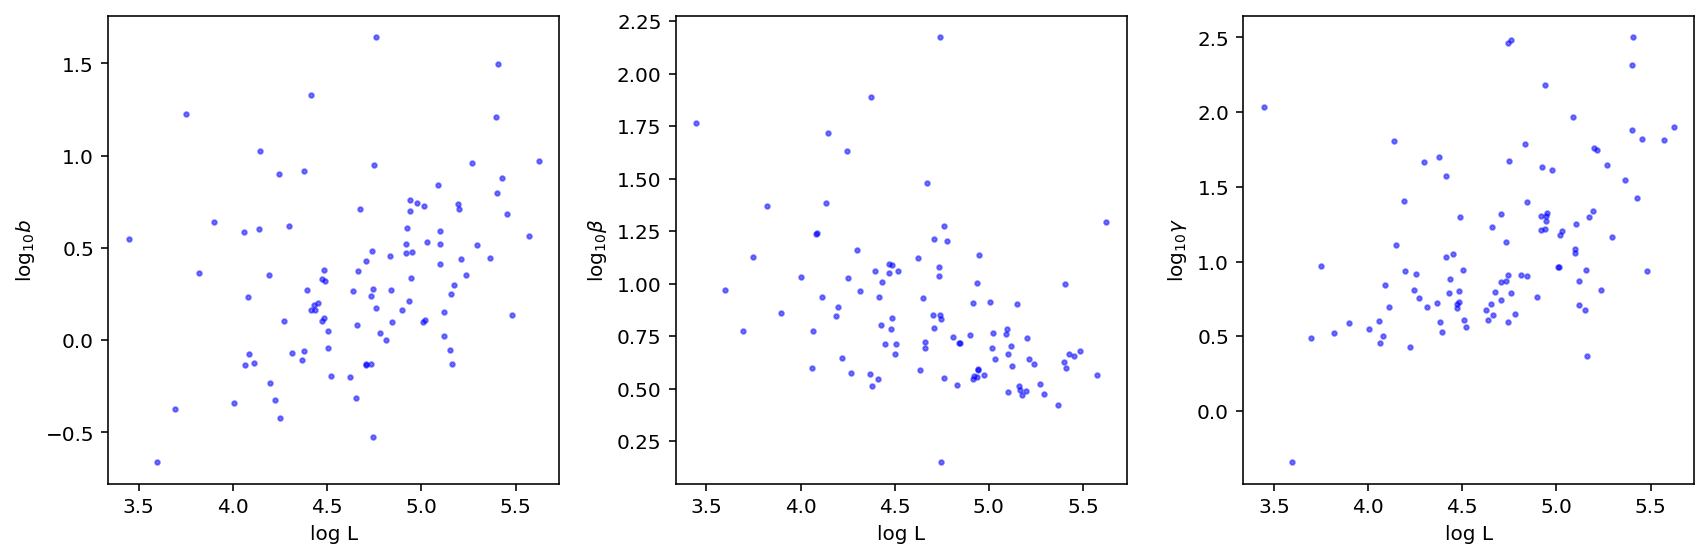

In [ ]:
plot_param_L_dep(result_data,plot_errorbars=False,nosamp=True)

### Fit quality analysis

Investigate the distribution of KL divergences at the optimal grid point. Only a few genes seem to have obviously poor fits (high KL divergence).

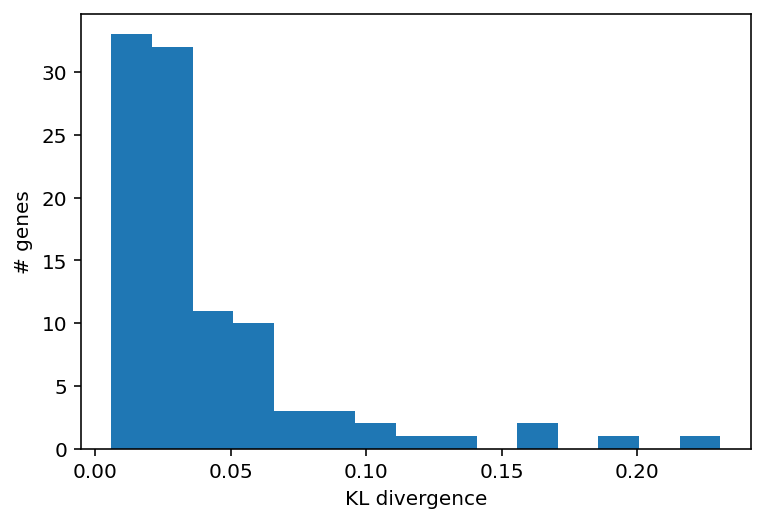

In [ ]:
plot_KL(result_data)

Compute the chi-squared statistic and $p$-values for all genes at the optimal grid point.

In [ ]:
(chisq,pval) = chisq_gen(result_data)

Is the $p$-value higher than 0.05/`n_gen`? The gene is retained. Lower? The gene is rejected due to potential model misspecification.

Output results of the chi-square test in an array corresponding to 1 = rejected, 0 = not rejected.


In [ ]:
sz = (10,10) 
figsize = (10,10)
title=True

In [ ]:
print(np.array(np.reshape(result_data.gene_rej,sz),dtype=int))

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [ ]:
print(str(np.sum(result_data.gene_rej))+' genes of '+str(result_data.n_gen)+' have been rejected by chi-square.')

2 genes of 100 have been rejected by chi-square.


Compare the actual raw data to the fits (points: raw data, contour plot: theoretical PMF). The fits seem to accurately reconstruct the molecular distributions. The rejected genes are HSPD1, ATRX, SLU7, COPE, and TCF4.

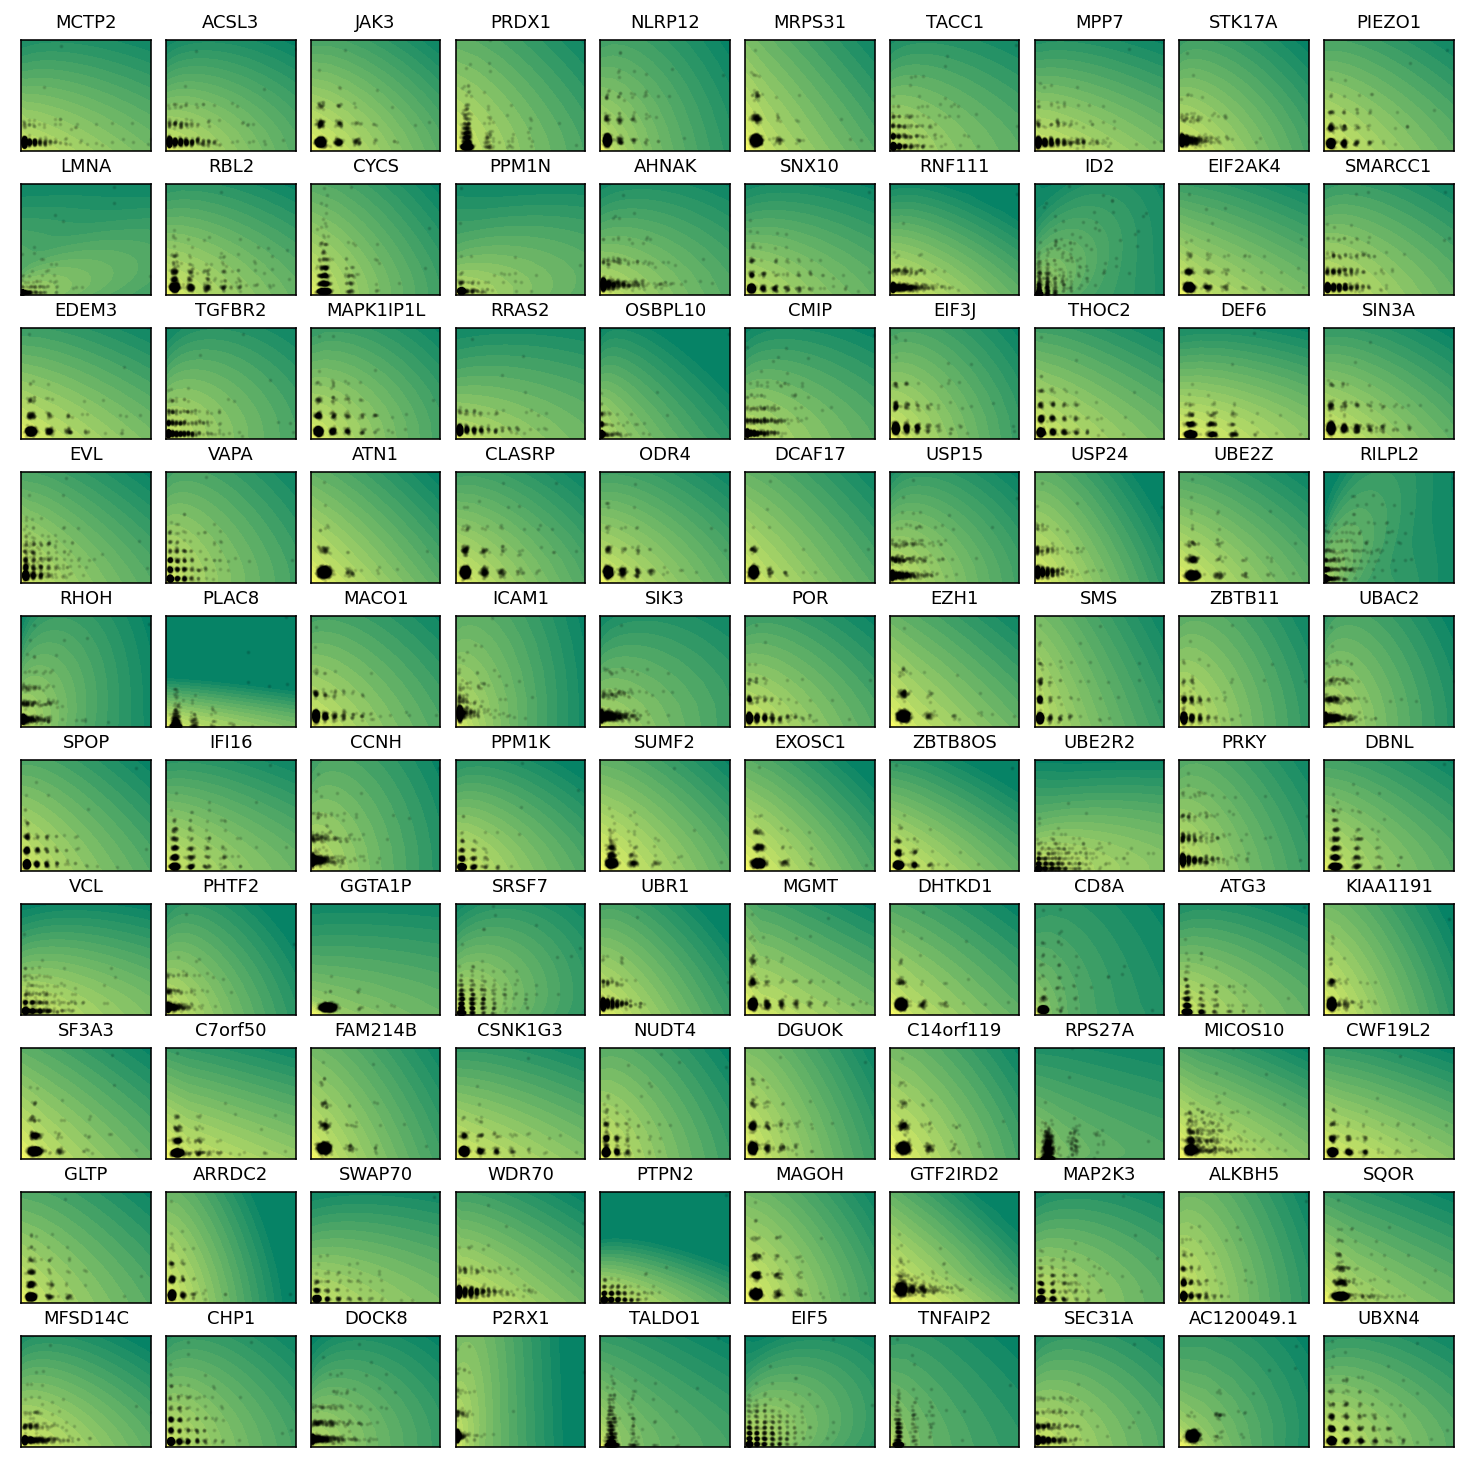

In [ ]:
plot_genes(result_data,sz,figsize,'none',log=True,title=title)

Plot the marginals. Again, the fits appear to be fairly good, although the data are sparse. Note the relatively poor fit to COPE, which supports the choice to reject.

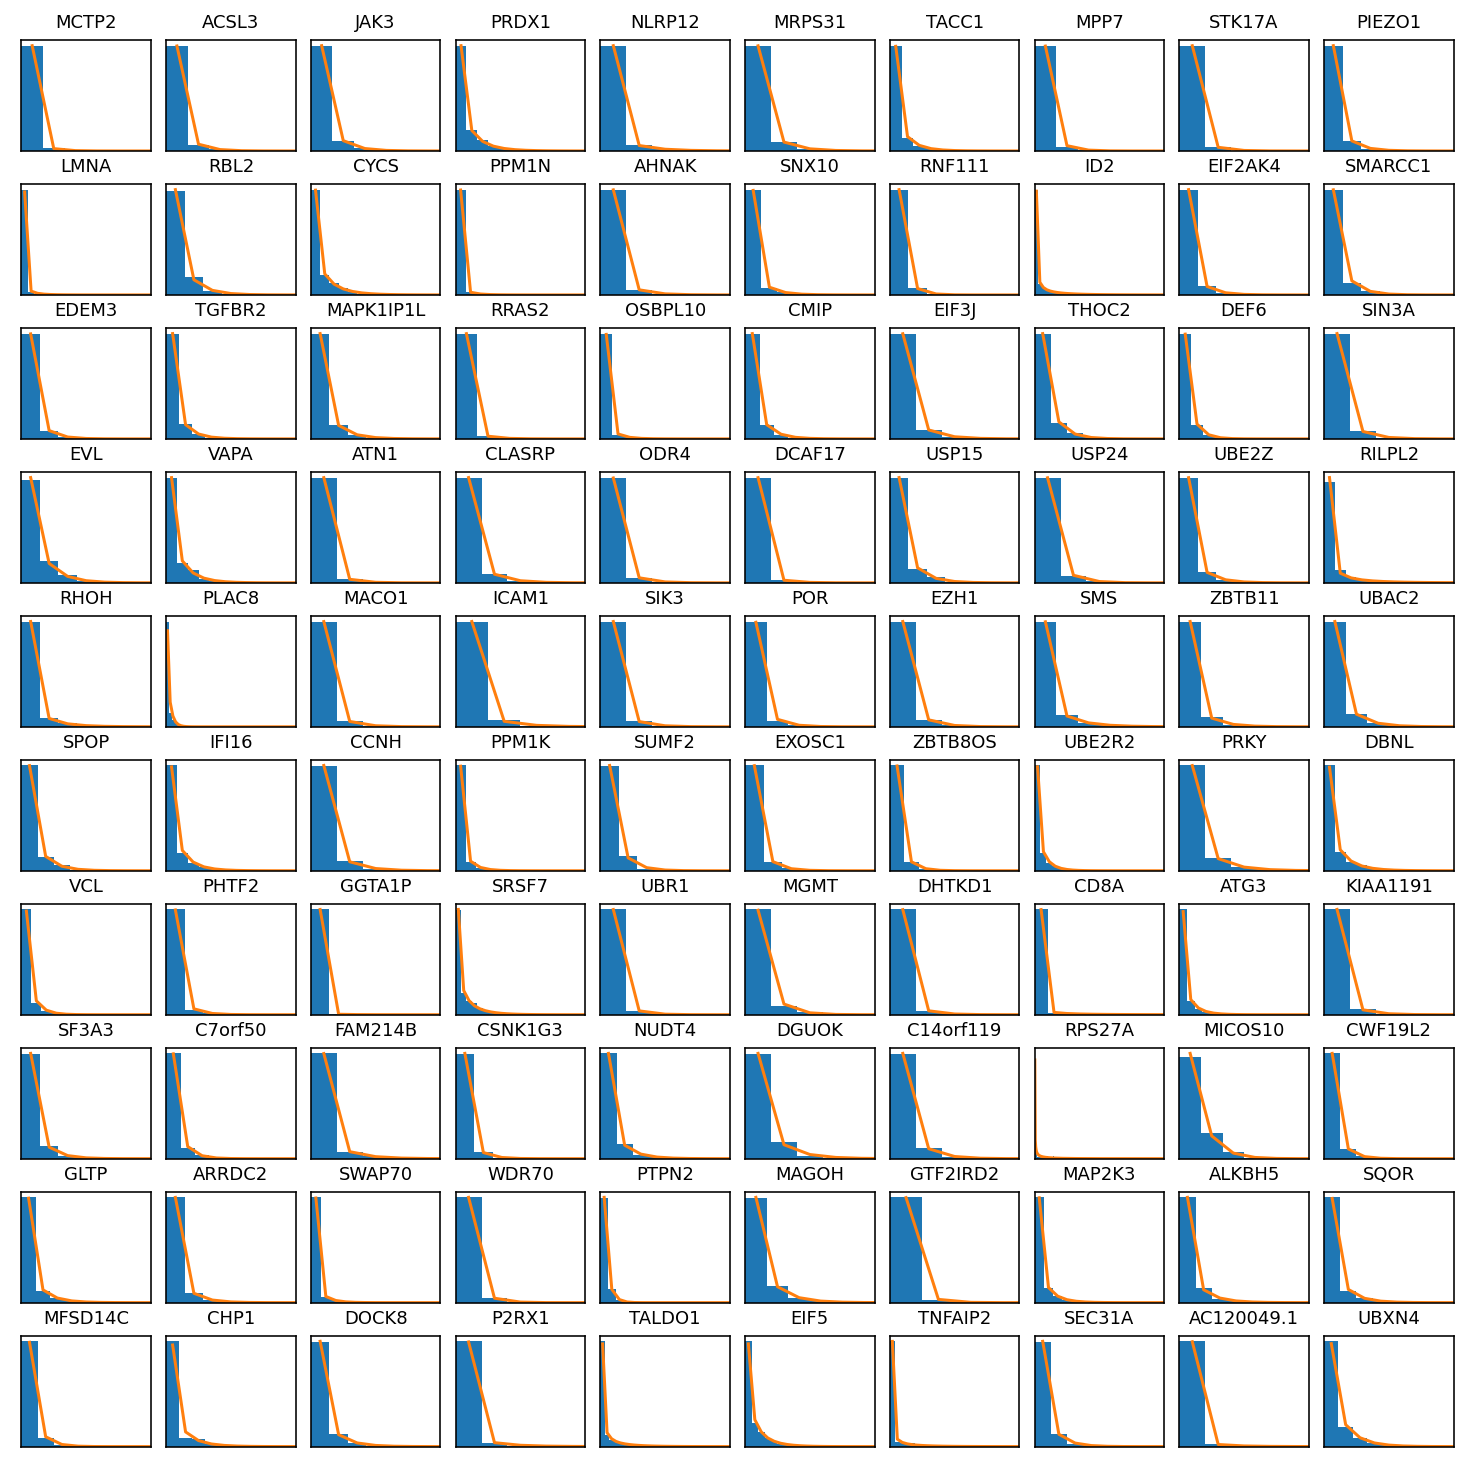

In [ ]:
plot_genes(result_data,sz,figsize,'mature',log=False,title=title)

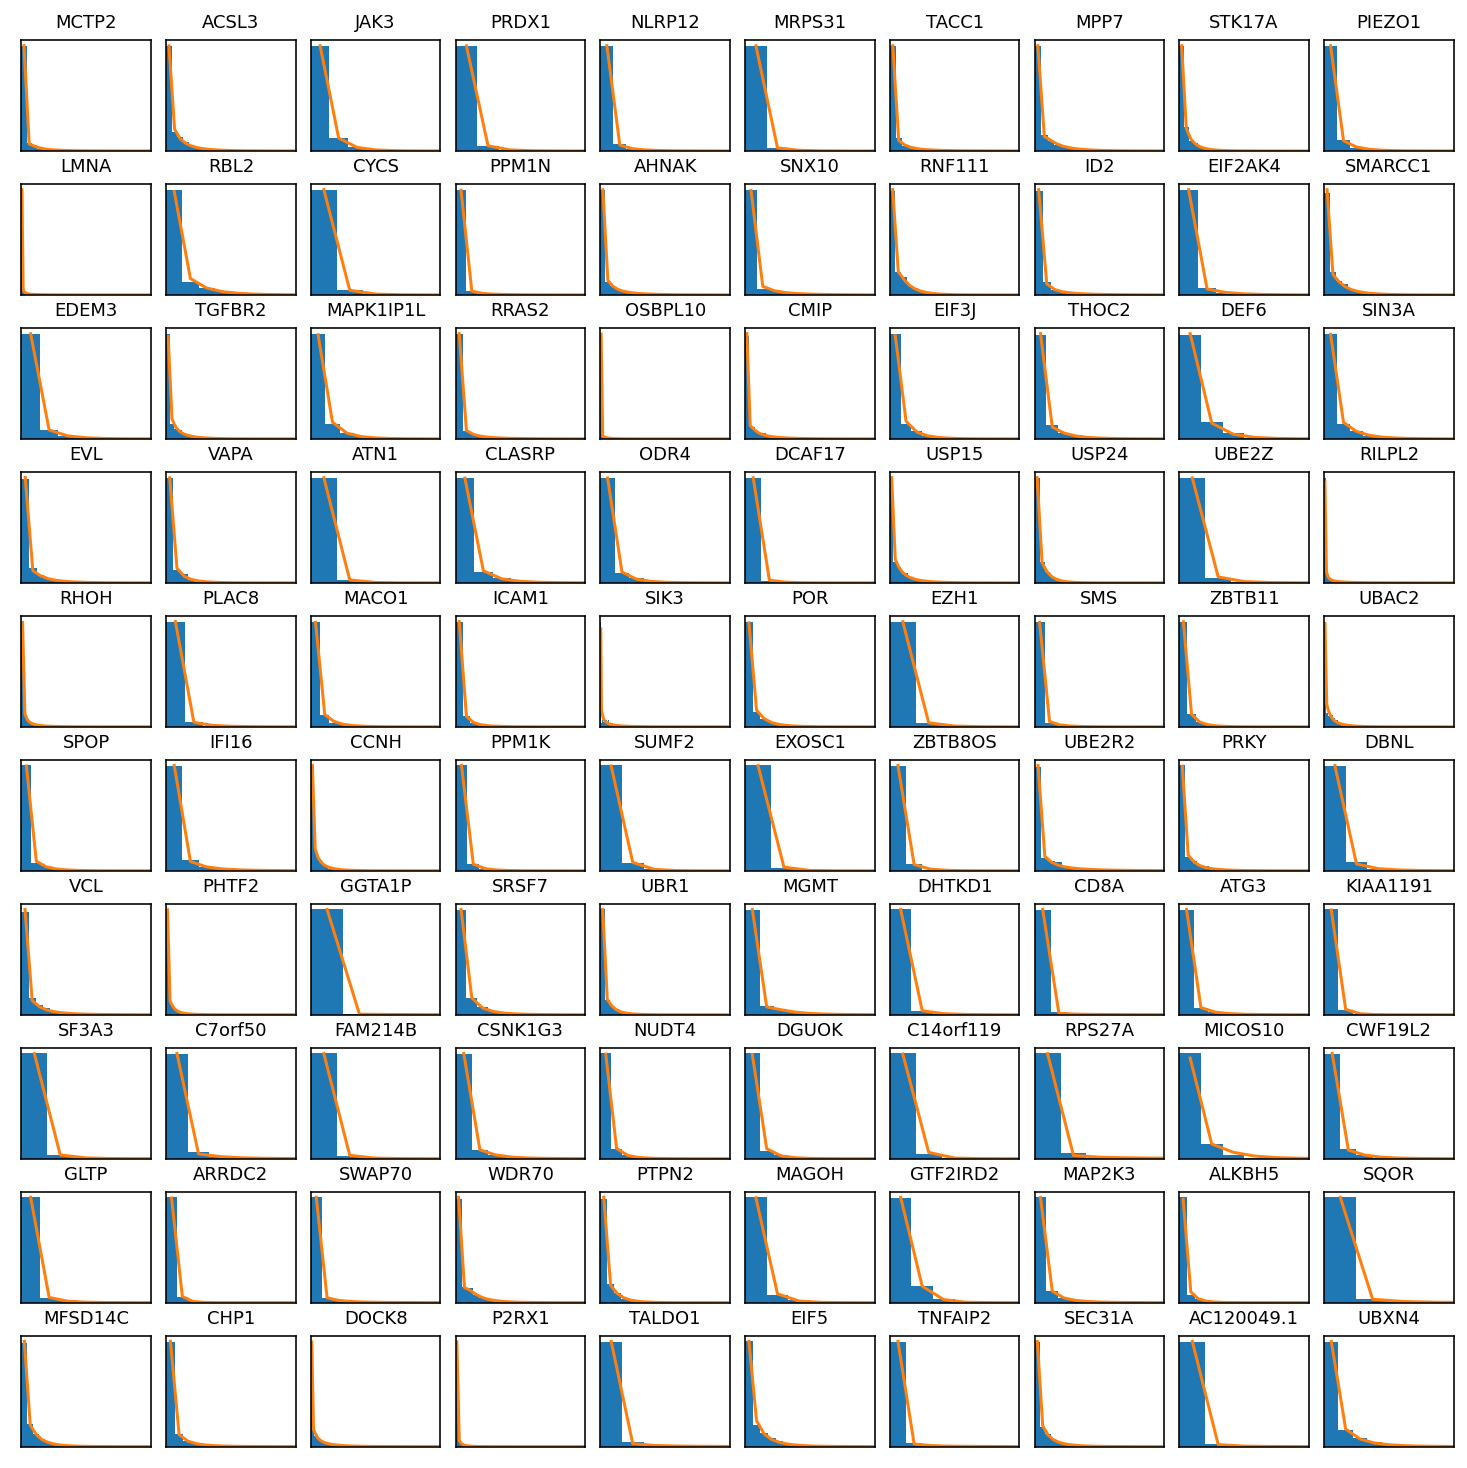

In [ ]:
plot_genes(result_data,sz,figsize,'nascent',log=False,title=title)

Test the stability of the optimum under self-consistent chi-squared testing: reject five genes, recompute the optimum based on all others, repeat. The optimum does not move.

(-5.5, -0.7999999999999998)

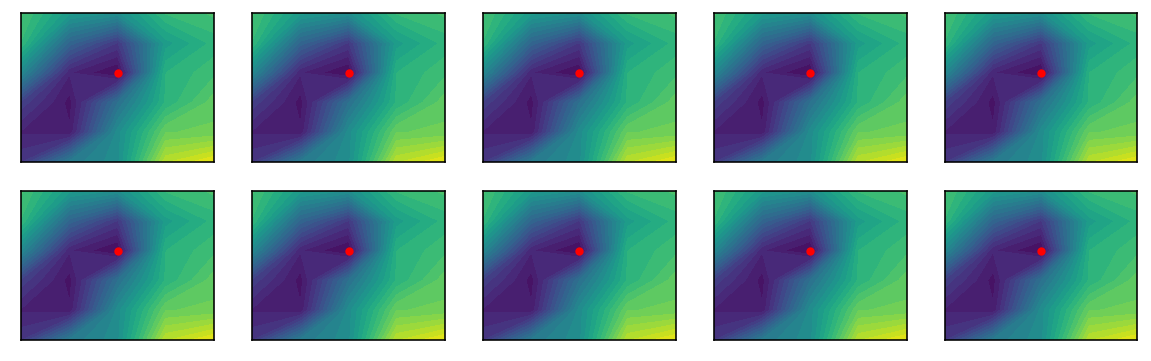

In [ ]:
chisq_best_param_correction(result_data,overwrite=True)

###Confidence interval construction

Compute conditional 99% confidence intervals for MLEs at the optimal grid point. These are fairly narrow, as there are a lot of cells. The genes rejected by the chi-squared test are excluded. We also plot a linear fit to the parameter trends, computed using weighted linear least squares. 

In [ ]:
compute_sigma(result_data)
compute_sigma(result_data,nosamp=True)

/content/seq_cme_inference.py:383: RuntimeWarning: invalid value encountered in sqrt
  errorbars[i,:] = c*np.sqrt(np.diag(hess_inv))/np.sqrt(result_data.Ncells)


Parameter set 87 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 78 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/content/seq_cme_inference.py:383: RuntimeWarning: invalid value encountered in sqrt
  errorbars[i,:] = c*np.sqrt(np.diag(hess_inv))/np.sqrt(result_data.Ncells)


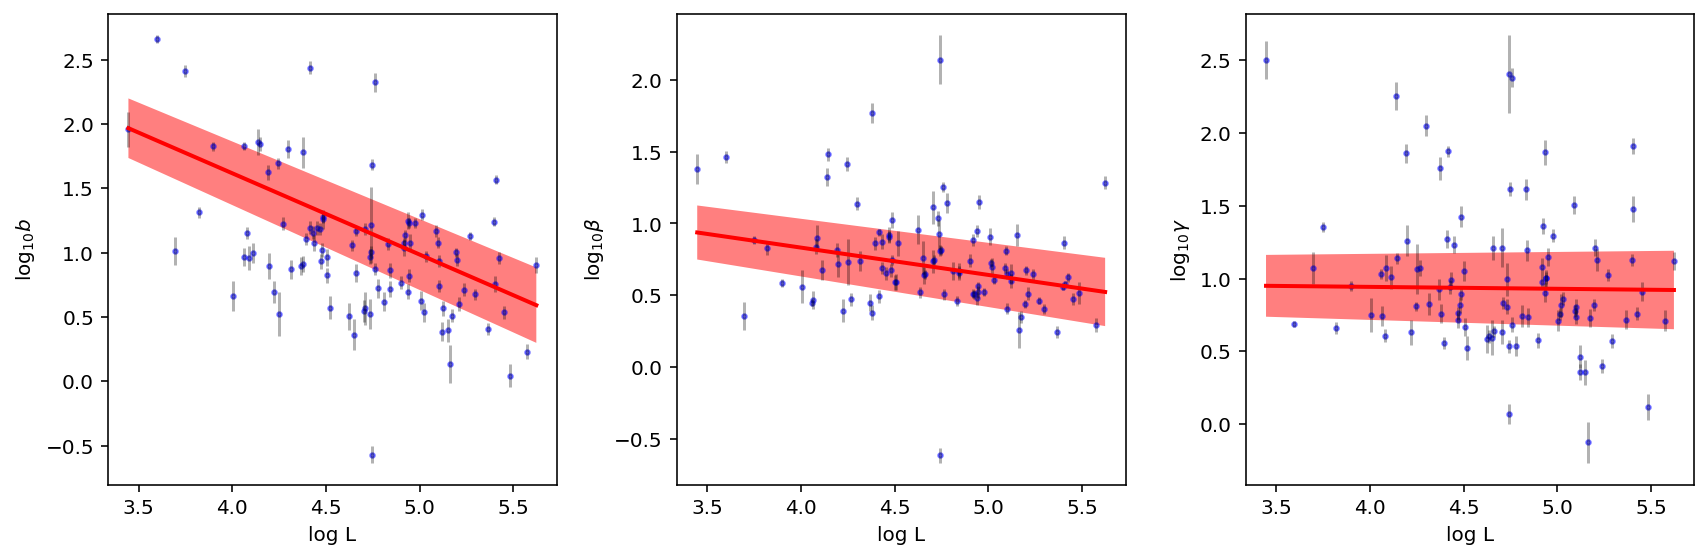

In [ ]:
plot_param_L_dep(result_data,plot_errorbars=True,chisq_correct=True,nosamp=False)

We repeat the procedure for the noise-free fit.

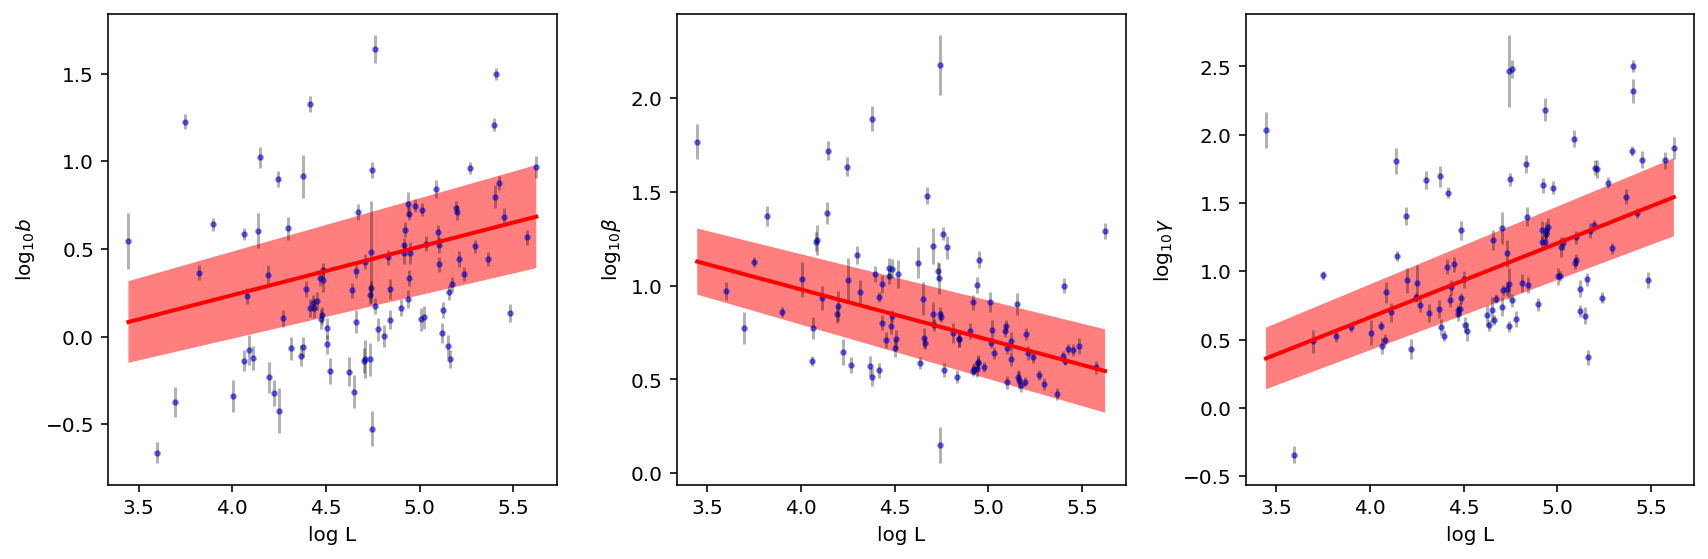

In [ ]:
_=chisq_gen(result_data,nosamp=True)
plot_param_L_dep(result_data,plot_errorbars=True,chisq_correct=True,nosamp=True)

In [ ]:
dt = time.time()-t1
print('{:.0f} seconds elapsed.'.format(dt))

332 seconds elapsed.
